<a href="https://colab.research.google.com/github/asyraffff/eICU-UMMC-Length-Of-Stay-Prediction/blob/main/1_Data_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
sns.set()

# import warning library to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option("display.max_rows", None)

In [ ]:
df_patient = pd.read_csv("drive/My Drive/FYP_LOS/dataset/patient.csv", low_memory=False)
df_apacheApsVar = pd.read_csv("drive/My Drive/FYP_LOS/dataset/apacheApsVar.csv", low_memory=False)
df_apachePredVar = pd.read_csv("drive/My Drive/FYP_LOS/dataset/apachePredVar.csv", low_memory=False)
df_apachePatientResult = pd.read_csv("drive/My Drive/FYP_LOS/dataset/apachePatientResult.csv", low_memory=False)

## Cohort selection

Selecting all ED-stays that had Cardiac-related diagnosis as their main (APACHE) admission diagnosis:

In [ ]:
[i for i in df_patient.apacheadmissiondx.value_counts().index.to_numpy() if "cardiac" in i]

['Coma/change in level of consciousness (for hepatic see GI, for diabetic see Endocrine, if related to cardiac arrest, see CV)',
 'Arrest, respiratory (without cardiac arrest)',
 'Ablation or mapping of cardiac conduction pathway',
 'Chest pain, atypical (noncardiac chest pain)',
 'Defibrillator, automatic implantable cardiac; insertion of',
 'Tumor removal, intracardiac']

In [ ]:
# cardiac patient
# but still the admission is not fully from Emergency department
# we will name the df "mix cardiac"
df_pat_card_mix = df_patient[df_patient['apacheadmissiondx'].str.contains('|'.join(['chf', 'congestive', '⁠rhythm disturbance',
                                                                  'atrial', 'cabg', 'myocardial', 'cardiac',
                                                                  'cardio', 'coronary', 'angina', 'heart',
                                                                  'chest',  'pulmonary edema','nstemi', 'ascites', 'acute',
                                                                  'Anteroseptal', 'Killip', 'acs', 'tro', 'stemi',
                                                                  'non ST Elevation Myocardial Infarction', 'syncope',
                                                                  'Hypertensive Emergency', 'syncopal',
                                                                  'Unstable Angina', 'Myocardial Infarction']),
                                                        na=False, case=False)].copy()
# list of cardiac patients
lst_pat = df_pat_card_mix.patientunitstayid.to_list()
len(lst_pat)

59202

→ **59202** ICU-admissions with a primary diagnosis of Cardiac

In [ ]:
# patients admitted from emergency department
df_pat_card_ed = df_pat_card_mix[df_pat_card_mix['hospitaladmitsource'] == "Emergency Department"].copy()

# list of patients
lst_pat = df_pat_card_ed.patientunitstayid.to_list()
len(lst_pat)

24432

→ **24432** ED-admissions with a primary diagnosis of Cardiac

## Data extraction

### Patient Data

Contains patient demographics and admission and discharge details for hospital and ED stays

In [ ]:
df_pat_card_ed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24432 entries, 9 to 200856
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patientunitstayid          24432 non-null  int64  
 1   patienthealthsystemstayid  24432 non-null  int64  
 2   gender                     24419 non-null  object 
 3   age                        24430 non-null  object 
 4   ethnicity                  24040 non-null  object 
 5   hospitalid                 24432 non-null  int64  
 6   wardid                     24432 non-null  int64  
 7   apacheadmissiondx          24432 non-null  object 
 8   admissionheight            23926 non-null  float64
 9   hospitaladmittime24        24432 non-null  object 
 10  hospitaladmitoffset        24432 non-null  int64  
 11  hospitaladmitsource        24432 non-null  object 
 12  hospitaldischargeyear      24432 non-null  int64  
 13  hospitaldischargetime24    24432 non-null  ob

In [ ]:
# Column selection
df_pat_card_ed = df_pat_card_ed[['patientunitstayid', 'gender', 'age', 'apacheadmissiondx',
                                  'hospitaladmitoffset','unitdischargeoffset', 'unitvisitnumber']]

In [ ]:
# Gender has an unknown values
df_pat_card_ed['gender'].value_counts()

Male       13530
Female     10882
Unknown        7
Name: gender, dtype: int64

In [ ]:
# Create a Length of Stay column
df_pat_card_ed['LOS_min'] = df_pat_card_ed['unitdischargeoffset'] - df_pat_card_ed['hospitaladmitoffset']
df_pat_card_ed = df_pat_card_ed.drop(['unitdischargeoffset', 'hospitaladmitoffset'], axis=1)

# Convert minutes to days
df_pat_card_ed['LOS'] = df_pat_card_ed['LOS_min'] / (24 * 60)
# df_pat_card_ed['LOS'] = df_pat_card_ed['LOS'].apply(math.ceil)  # Round up to the nearest whole number
df_pat_card_ed = df_pat_card_ed.drop(['LOS_min'], axis=1)

# Replace 0 values in 'length_of_stay' column with 1
# 0 days = 1 days
# df_pat_card_ed['LOS'].replace(0, 1, inplace=True)

# gender column
df_pat_card_ed["gender"] = df_pat_card_ed["gender"].replace({"Unknown": np.nan, "Other": np.nan})

# age column
df_pat_card_ed["age"] = df_pat_card_ed["age"].replace("> 89", "90")
df_pat_card_ed["age"] = pd.to_numeric(df_pat_card_ed["age"])

# remove pediatric patients
df_pat_card_ed = df_pat_card_ed[df_pat_card_ed["age"] >= 18]

# filter 'unitvisitnumber' more than 1 ED Stay
df_pat_card_ed = df_pat_card_ed[df_pat_card_ed['unitvisitnumber'] <= 1]
df_pat_card_ed = df_pat_card_ed.drop(['unitvisitnumber'], axis=1)

# len(df_pat_card_ed)
df_pat_card_ed.describe(include="all")

,patientunitstayid,gender,age,apacheadmissiondx,LOS
count,2.186600e+04,21848,21866.000000,21866,21866.000000
unique,NaN,2,NaN,60,NaN
top,NaN,Male,NaN,"Infarction, acute myocardial (MI)",NaN
freq,NaN,12058,NaN,3322,NaN
mean,1.647755e+06,NaN,64.648038,NaN,2.631008
std,1.003511e+06,NaN,15.938125,NaN,3.432610
min,1.412290e+05,NaN,18.000000,NaN,-5.338194
25%,8.286478e+05,NaN,54.000000,NaN,0.972222
50%,1.521812e+06,NaN,66.000000,NaN,1.668056
75%,2.619582e+06,NaN,77.000000,NaN,2.940278


### ApacheApsVar data

Contains the variables used to calculate the **Acute Physiology Score (APS) III** for patients. APS-III is an established method of **summarizing patient severity of illness** on admission to the ICU, and is a part of the **Acute Physiology Age Chronic Health Evaluation (APACHE)** system of equations for predicting outcomes for ICU patients.

In [ ]:
df_apacheApsVar.head()

,apacheapsvarid,patientunitstayid,intubated,vent,dialysis,eyes,motor,verbal,meds,urine,wbc,temperature,respiratoryrate,sodium,heartrate,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2
0,2,141168,0,0,0,4,6,5,0,-1.0,14.7,36.1,30.0,139.0,140,62.0,-1.00,40.1,2.30,3.1,-1.0,-1.0,27.0,95.0,4.1,-1.0
1,2399659,141178,0,0,0,-1,-1,-1,-1,-1.0,-1.0,36.4,16.0,-1.0,88,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,167885,141194,0,0,0,3,6,4,0,-1.0,14.1,39.3,36.0,134.0,118,40.0,-1.00,27.4,2.51,2.3,-1.0,-1.0,31.0,168.0,0.4,-1.0
3,70691,141197,0,0,0,4,6,5,0,-1.0,-1.0,-1.0,25.0,-1.0,104,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2279689,141203,0,1,0,1,3,1,0,-1.0,12.7,35.1,33.0,145.0,120,46.0,7.45,36.9,0.56,-1.0,51.0,37.0,9.0,145.0,-1.0,100.0


In [ ]:
# drop columns that are not required
df_apacheApsVar = df_apacheApsVar.drop(['apacheapsvarid','vent','dialysis', 'eyes',
                                        'motor', 'verbal', 'meds', 'urine', 'temperature',
                                        'ph', 'pao2', 'pco2', 'fio2', 'albumin', 'bilirubin'],axis=1)

In [ ]:
df_apacheApsVar.describe(include='all')

,patientunitstayid,intubated,wbc,respiratoryrate,sodium,heartrate,meanbp,hematocrit,creatinine,bun,glucose
count,1.711770e+05,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000
mean,1.747701e+06,0.148373,8.905202,24.784735,108.366800,98.667993,85.058000,24.716856,0.999311,20.681516,141.184455
std,9.988850e+05,0.355470,9.100861,15.301895,57.117164,33.263814,42.970431,15.452859,1.852455,22.618132,109.723423
min,1.411680e+05,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,9.555340e+05,0.000000,-1.000000,10.000000,129.000000,84.000000,53.000000,19.300000,0.470000,7.000000,85.000000
50%,1.670376e+06,0.000000,8.300000,27.000000,137.000000,104.000000,65.000000,29.700000,0.810000,15.000000,115.000000
75%,2.743419e+06,0.000000,13.400000,35.000000,140.000000,120.000000,123.000000,35.900000,1.360000,28.000000,187.000000
max,3.353263e+06,1.000000,198.100000,60.000000,195.000000,220.000000,200.000000,72.700000,24.950000,254.000000,2357.000000


### ApachePredVar data

Provides variables underlying the **APACHE predictions**. Acute Physiology Age Chronic Health Evaluation (APACHE) consists of a groups of equations used for predicting outcomes in critically ill patients

In [ ]:
df_apachePredVar.head()

,apachepredvarid,patientunitstayid,sicuday,saps3day1,saps3today,saps3yesterday,gender,teachtype,region,bedcount,admitsource,graftcount,meds,verbal,motor,eyes,age,admitdiagnosis,thrombolytics,diedinhospital,aids,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,electivesurgery,activetx,readmit,ima,midur,ventday1,oobventday1,oobintubday1,diabetes,managementsystem,var03hspxlos,pao2,fio2,ejectfx,creatinine,dischargelocation,visitnumber,amilocation,day1meds,day1verbal,day1motor,day1eyes,day1pao2,day1fio2
0,1794895,141168,1,0,0,0,1,0,3,12,7,3,0,5,6,4,70.0,RHYTHATR,0,1,0,0,0,0,0,0,0,NaN,1,0,0,0,0,0,0,0,1,0,-1.0,-1.0,-1,2.30,9,1,-1,0,5,6,4,-1.0,-1.0
1,2406430,141178,1,0,0,0,1,0,3,9,8,3,-1,-1,-1,-1,52.0,NaN,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,-1.0,-1.0,-1,-1.00,4,1,-1,-1,-1,-1,-1,-1.0,-1.0
2,1790923,141194,1,0,0,0,0,0,3,38,4,3,0,4,6,3,68.0,SEPSISUTI,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,1,1,0,-1.0,-1.0,-1,2.51,4,1,-1,0,4,6,3,-1.0,-1.0
3,27799,141197,1,0,0,0,0,0,3,30,8,3,0,5,6,4,71.0,SEPSISPULM,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,-1.0,-1.0,-1,-1.00,4,1,-1,0,5,6,4,-1.0,-1.0
4,2406432,141203,1,0,0,0,1,0,3,18,4,3,0,1,3,1,77.0,RESPARREST,0,0,0,0,0,0,0,0,0,NaN,1,0,0,0,1,1,0,1,1,0,51.0,100.0,-1,0.56,4,1,-1,0,1,3,1,51.0,100.0


In [ ]:
df_apachePredVar = df_apachePredVar[['patientunitstayid', 'thrombolytics', 'metastaticcancer', 'cirrhosis', 'diabetes']]

In [ ]:
df_apachePredVar.describe(include='all')

,patientunitstayid,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,1.711770e+05,171177.000000,171177.000000,171177.000000,171177.000000
mean,1.747701e+06,0.016194,0.021118,0.018443,0.229634
std,9.988850e+05,0.126221,0.143780,0.134547,0.420598
min,1.411680e+05,0.000000,0.000000,0.000000,0.000000
25%,9.555340e+05,0.000000,0.000000,0.000000,0.000000
50%,1.670376e+06,0.000000,0.000000,0.000000,0.000000
75%,2.743419e+06,0.000000,0.000000,0.000000,0.000000
max,3.353263e+06,1.000000,1.000000,1.000000,1.000000


### ApachePatientResult data

Provides predictions made by the APACHE score (versions IV and IVa), including probability of mortality, **length of stay**, and ventilation days.

In [ ]:
df_apachePatientResult.head()

,apachepatientresultsid,patientunitstayid,physicianspeciality,physicianinterventioncategory,acutephysiologyscore,apachescore,apacheversion,predictedicumortality,actualicumortality,predictediculos,actualiculos,predictedhospitalmortality,actualhospitalmortality,predictedhospitallos,actualhospitallos,preopmi,preopcardiaccath,ptcawithin24h,unabridgedunitlos,unabridgedhosplos,actualventdays,predventdays,unabridgedactualventdays
0,26570,141168,critical care medicine (CCM),Unknown,49,65,IV,0.026988,EXPIRED,3.038388,2.4972,0.079880,EXPIRED,7.546453,2.4972,0,0,0,2.4972,2.4972,NaN,NaN,NaN
1,26571,141168,critical care medicine (CCM),Unknown,49,65,IVa,0.028889,EXPIRED,3.091127,2.4972,0.059099,EXPIRED,6.628720,2.4972,0,0,0,2.4972,2.4972,NaN,NaN,NaN
2,53135,141194,critical care medicine (CCM),Unknown,57,70,IV,0.037888,ALIVE,4.620982,3.3423,0.098445,ALIVE,13.338449,9.2167,0,0,0,3.3423,9.2167,NaN,NaN,NaN
3,53136,141194,critical care medicine (CCM),Unknown,57,70,IVa,0.046448,ALIVE,4.167129,3.3423,0.102283,ALIVE,12.978228,9.2167,0,0,0,3.3423,9.2167,NaN,NaN,NaN
4,8,141203,hospitalist,I,73,90,IVa,0.291609,ALIVE,8.670299,1.2979,0.470973,ALIVE,16.319389,3.7493,0,0,0,1.2979,3.7493,2.0,5.738093,2.0


In [ ]:
df_apachePatientResult = df_apachePatientResult[['patientunitstayid', 'predictediculos',
                                                 'actualiculos', 'predictedhospitallos', 'actualhospitallos']]

In [ ]:
df_apachePatientResult.describe(include='all')

,patientunitstayid,predictediculos,actualiculos,predictedhospitallos,actualhospitallos
count,2.970640e+05,297064.000000,297064.000000,297064.000000,297064.000000
mean,1.743594e+06,3.595447,3.002518,9.027666,8.054302
std,9.970573e+05,2.222920,4.296411,5.388297,8.146806
min,1.411680e+05,-1.000000,0.166600,-1.000000,0.107600
25%,9.678328e+05,1.996826,0.985400,6.014604,2.940300
50%,1.662513e+06,3.215731,1.810750,8.834722,5.514600
75%,2.728990e+06,4.955739,3.294400,11.905690,9.981900
max,3.353263e+06,19.907512,345.793700,170.886872,50.000000


### Merging data

In [ ]:
df_cardiac = pd.merge(left = df_pat_card_ed, right = df_apacheApsVar, how='left', on="patientunitstayid")

df_cardiac = df_cardiac.merge(right = df_apachePredVar, how='left', on="patientunitstayid")

In [ ]:
df_cardiac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21866 entries, 0 to 21865
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientunitstayid  21866 non-null  int64  
 1   gender             21848 non-null  object 
 2   age                21866 non-null  float64
 3   apacheadmissiondx  21866 non-null  object 
 4   LOS                21866 non-null  float64
 5   intubated          20854 non-null  float64
 6   wbc                20854 non-null  float64
 7   respiratoryrate    20854 non-null  float64
 8   sodium             20854 non-null  float64
 9   heartrate          20854 non-null  float64
 10  meanbp             20854 non-null  float64
 11  hematocrit         20854 non-null  float64
 12  creatinine         20854 non-null  float64
 13  bun                20854 non-null  float64
 14  glucose            20854 non-null  float64
 15  thrombolytics      20854 non-null  float64
 16  metastaticcancer   208

In [ ]:
# change order of columns
df_cardiac = df_cardiac[['patientunitstayid', 'gender', 'age', 'apacheadmissiondx', 'LOS',
                         'intubated', 'wbc', 'respiratoryrate', 'heartrate',
                         'sodium', 'meanbp', 'hematocrit', 'creatinine', 'bun',
                         'glucose', 'thrombolytics', 'metastaticcancer', 'cirrhosis', 'diabetes']]

df_cardiac.describe(include='all')

,patientunitstayid,gender,age,apacheadmissiondx,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,2.186600e+04,21848,21866.000000,21866,21866.000000,20854.000000,20854.000000,20854.000000,20854.000000,20854.000000,20854.000000,20854.000000,20854.000000,20854.000000,20854.000000,20854.000000,20854.000000,20854.000000,20854.000000
unique,NaN,2,NaN,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Male,NaN,"Infarction, acute myocardial (MI)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,12058,NaN,3322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.647755e+06,NaN,64.648038,NaN,2.631008,0.122950,7.504704,24.688770,94.135514,104.864635,92.219429,24.814681,1.190971,21.674782,137.954416,0.056056,0.011125,0.010981,0.233576
std,1.003511e+06,NaN,15.938125,NaN,3.432610,0.328388,8.091782,15.029196,33.221619,59.196198,42.689172,17.366246,2.369220,25.298650,108.560542,0.230036,0.104889,0.104216,0.423116
min,1.412290e+05,NaN,18.000000,NaN,-5.338194,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,8.286478e+05,NaN,54.000000,NaN,0.972222,0.000000,-1.000000,11.000000,60.000000,119.000000,55.000000,-1.000000,0.420000,5.000000,85.000000,0.000000,0.000000,0.000000,0.000000
50%,1.521812e+06,NaN,66.000000,NaN,1.668056,0.000000,7.500000,26.000000,100.000000,137.000000,72.000000,31.800000,0.880000,16.000000,111.000000,0.000000,0.000000,0.000000,0.000000
75%,2.619582e+06,NaN,77.000000,NaN,2.940278,0.000000,11.300000,35.000000,116.000000,140.000000,129.000000,38.100000,1.490000,28.000000,185.000000,0.000000,0.000000,0.000000,0.000000


### Finding number of missing or null values

In [ ]:
df_cardiac.isnull().sum()

patientunitstayid       0
gender                 18
age                     0
apacheadmissiondx       0
LOS                     0
intubated            1012
wbc                  1012
respiratoryrate      1012
heartrate            1012
sodium               1012
meanbp               1012
hematocrit           1012
creatinine           1012
bun                  1012
glucose              1012
thrombolytics        1012
metastaticcancer     1012
cirrhosis            1012
diabetes             1012
dtype: int64

In [ ]:
!pip install missingno

In [ ]:
# make a df copy to check the null data
check_null_df = df_cardiac.copy()

In [ ]:
# length of patient data before dropping null columns
len(check_null_df)

21866

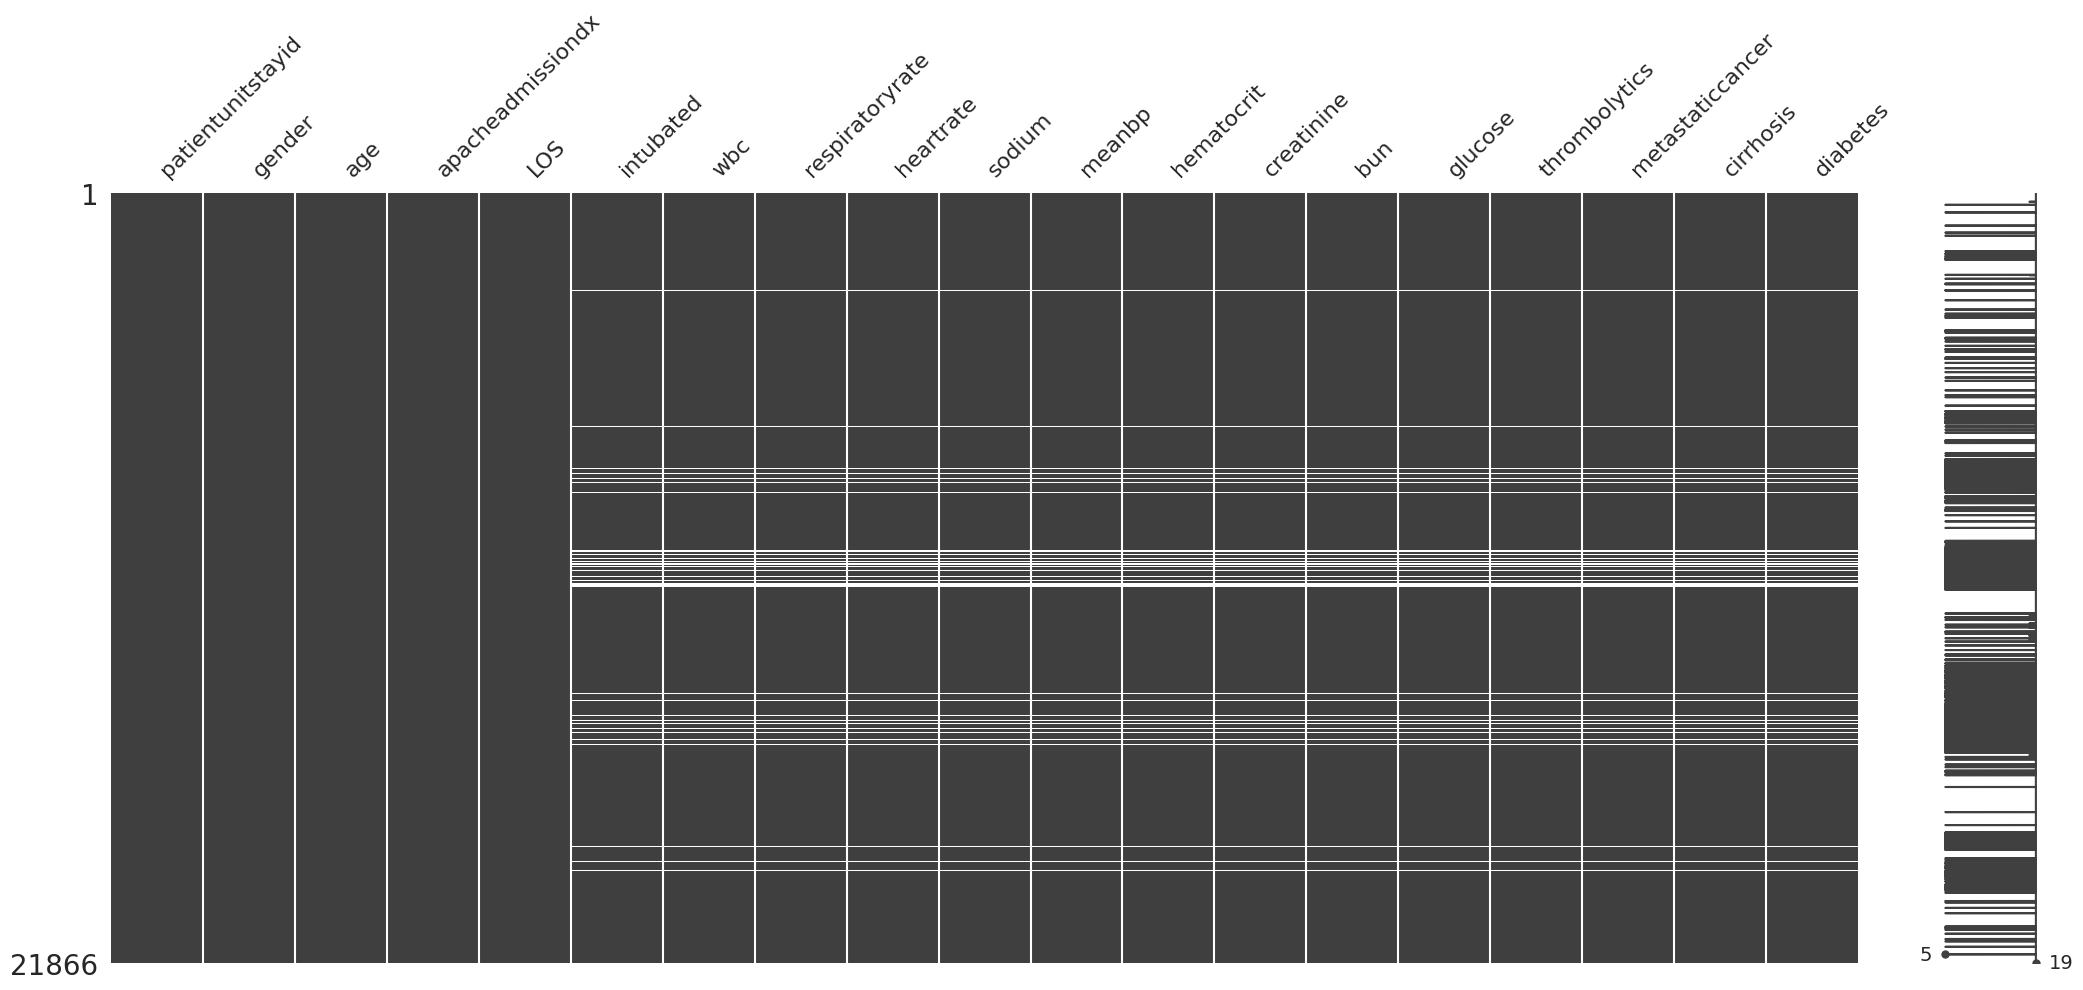

In [ ]:
import missingno as msno

# Plot correlation heatmap of missingness
msno.matrix(check_null_df);

inference :

*   There's a high corelation between `intubated` until `diabetes` column for a few rows




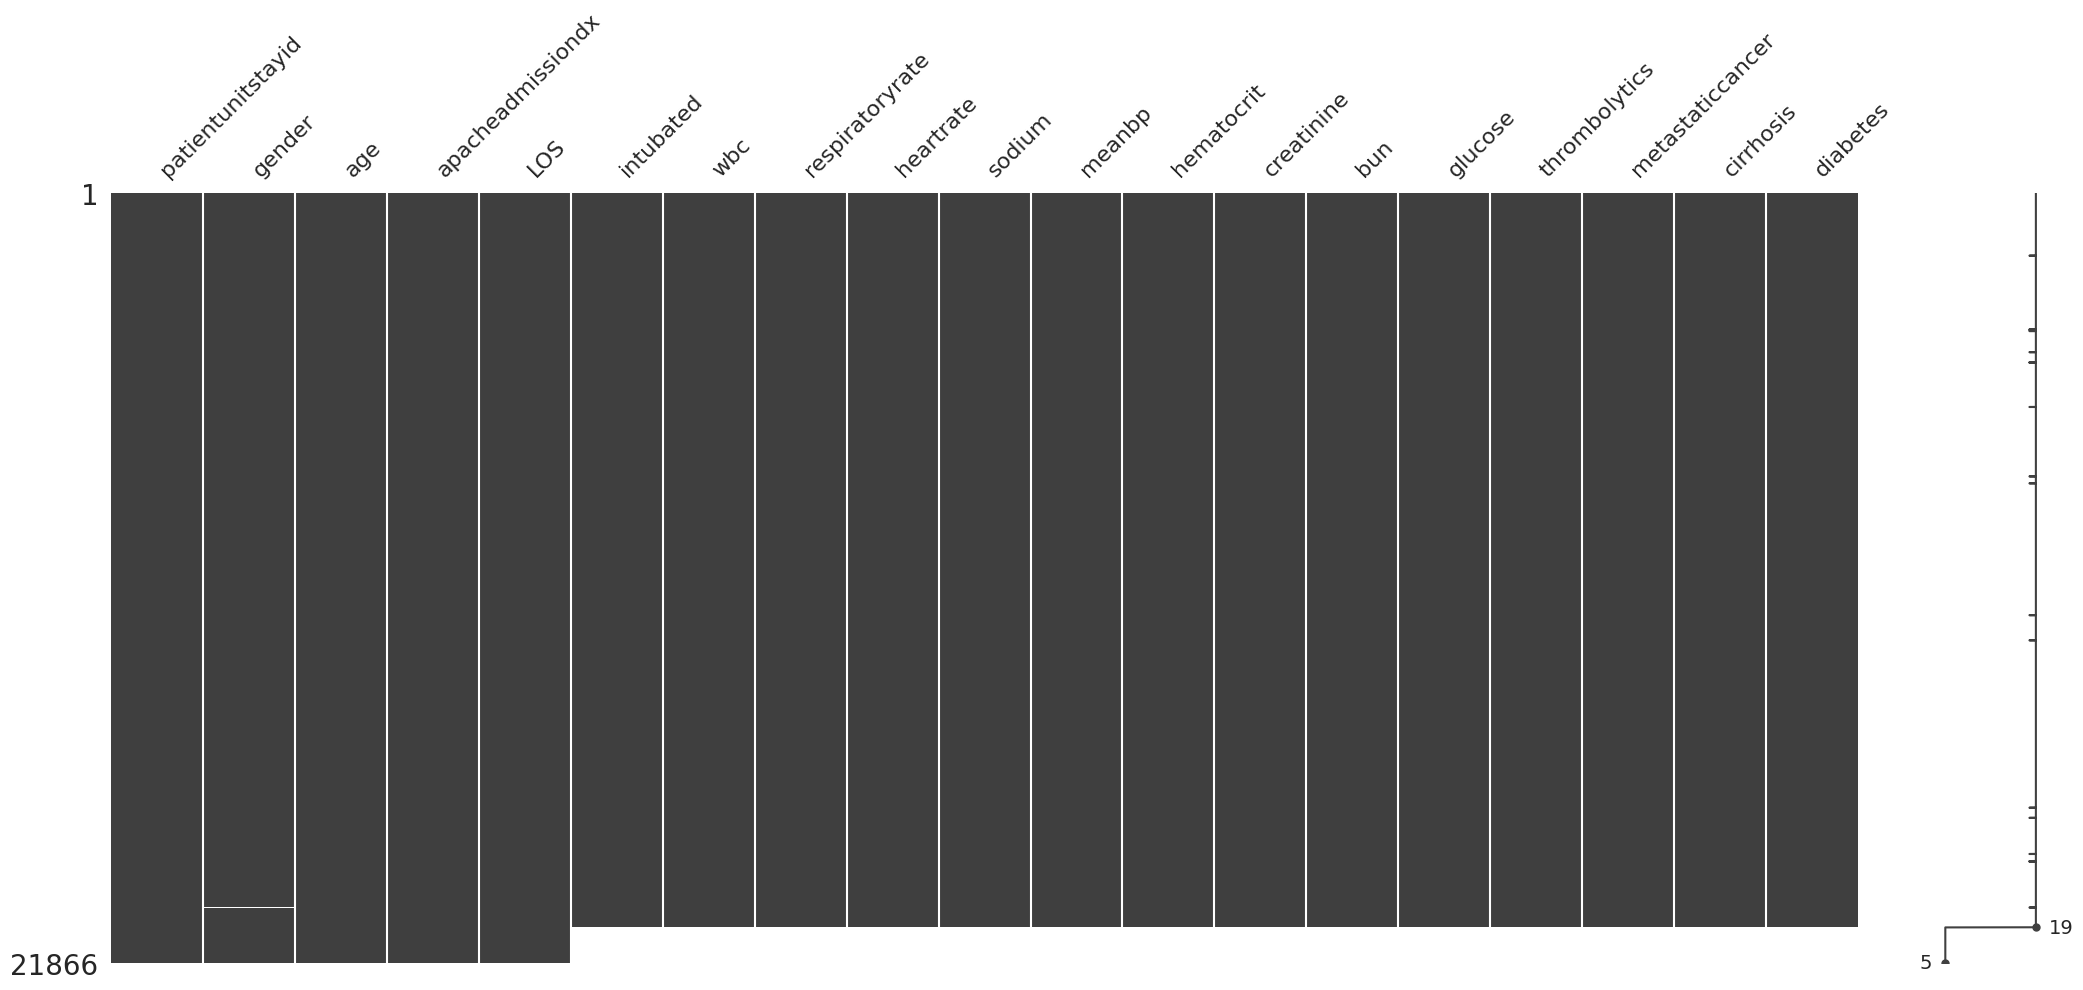

In [ ]:
msno.matrix(check_null_df.sort_values("intubated"));

inference:

*   We can confirm a high correlation between missing data in the `intubated` until `diabetes` column for some rows.

In [ ]:
# length of patient data after dropping all null values
check_null_df = check_null_df.dropna()
len(check_null_df)

20836

In [ ]:
# dropping all null values in the real dataset
df_cardiac = df_cardiac.dropna()

In [ ]:
df_cardiac.isnull().sum()

patientunitstayid    0
gender               0
age                  0
apacheadmissiondx    0
LOS                  0
intubated            0
wbc                  0
respiratoryrate      0
heartrate            0
sodium               0
meanbp               0
hematocrit           0
creatinine           0
bun                  0
glucose              0
thrombolytics        0
metastaticcancer     0
cirrhosis            0
diabetes             0
dtype: int64

## Feature Engineering

### Encoding the categorical values

Adding columns having the encoded values for `admission diagnosis`, and `gender`

In [ ]:
lb_make = LabelEncoder()

df_cardiac['gender'] = df_cardiac['gender'].astype('category')
df_cardiac['apacheadmissiondx'] = df_cardiac['apacheadmissiondx'].astype('category')

In [ ]:
df_cardiac['gender_code'] = df_cardiac['gender'].map({"Male":0, "Female":1})
df_cardiac['diagnosis_code'] = lb_make.fit_transform(df_cardiac['apacheadmissiondx'])
df_cardiac.head()

,patientunitstayid,gender,age,apacheadmissiondx,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes,gender_code,diagnosis_code
0,141229,Female,90.0,"CHF, congestive heart failure",0.118056,0.0,-1.0,32.0,57.0,-1.0,73.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,1,15
1,141328,Female,76.0,"CHF, congestive heart failure",0.428472,0.0,-1.0,14.0,66.0,-1.0,156.0,-1.0,-1.0,-1.0,103.0,0.0,0.0,0.0,0.0,1,15
2,141360,Male,48.0,"CVA, cerebrovascular accident/stroke",2.179861,0.0,-1.0,28.0,106.0,-1.0,140.0,-1.0,-1.0,-1.0,98.0,0.0,0.0,0.0,0.0,0,16
3,141436,Male,46.0,"Arrest, respiratory (without cardiac arrest)",1.504861,1.0,9.7,34.0,114.0,132.0,113.0,44.2,1.0,15.0,143.0,0.0,0.0,0.0,0.0,0,6
4,141448,Male,65.0,Coma/change in level of consciousness (for hep...,0.682639,0.0,5.0,4.0,98.0,-1.0,55.0,33.3,-1.0,-1.0,88.0,0.0,0.0,0.0,0.0,0,34


In [ ]:
# Table of Diagnosis code with its descriptions

# Drop duplicates to have unique combinations of diagnosis code and description
unique_df_dc = df_cardiac.drop_duplicates().sort_values(by='diagnosis_code')

# Grouping by 'diagnosis_code' and aggregating 'apacheadmissiondx' descriptions
grouped_dc = unique_df_dc.groupby('diagnosis_code')['apacheadmissiondx'].apply(lambda x: '\n'.join(x))

print(grouped_dc.to_string())

diagnosis_code
0     ARDS-adult respiratory distress syndrome, non-...
1     Ablation or mapping of cardiac conduction path...
2     Acid-base/electrolyte disturbance\nAcid-base/e...
3     Amyotrophic lateral sclerosis\nAmyotrophic lat...
4     Angina, stable (asymp or stable pattern of sym...
5     Angina, unstable (angina interferes w/quality ...
6     Arrest, respiratory (without cardiac arrest)\n...
7     Bleeding-variceal, surgery for (excluding vasc...
8     CABG alone, coronary artery bypass grafting\nC...
9                    CABG alone, redo\nCABG alone, redo
10                       CABG redo with other operation
11    CABG redo with valve repair/replacement\nCABG ...
12    CABG with aortic valve replacement\nCABG with ...
13    CABG with mitral valve repair\nCABG with mitra...
14    CABG with other operation\nCABG with other ope...
15    CHF, congestive heart failure\nCHF, congestive...
16    CVA, cerebrovascular accident/stroke\nCVA, cer...
17    Cardiac arrest (with or wit

In [ ]:
df_cardiac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20836 entries, 0 to 21865
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   patientunitstayid  20836 non-null  int64   
 1   gender             20836 non-null  category
 2   age                20836 non-null  float64 
 3   apacheadmissiondx  20836 non-null  category
 4   LOS                20836 non-null  float64 
 5   intubated          20836 non-null  float64 
 6   wbc                20836 non-null  float64 
 7   respiratoryrate    20836 non-null  float64 
 8   heartrate          20836 non-null  float64 
 9   sodium             20836 non-null  float64 
 10  meanbp             20836 non-null  float64 
 11  hematocrit         20836 non-null  float64 
 12  creatinine         20836 non-null  float64 
 13  bun                20836 non-null  float64 
 14  glucose            20836 non-null  float64 
 15  thrombolytics      20836 non-null  float64 
 16  meta

In [ ]:
# change gender column name
df_cardiac.rename(columns={'gender': 'gender_not_use'}, inplace=True)

# drop gender_not_use column
df_cardiac = df_cardiac.drop(['gender_not_use'], axis=1)

# change gender_code column name to gender
df_cardiac.rename(columns={'gender_code': 'gender'}, inplace=True)

# change the gender type from category to int
df_cardiac['gender'] = df_cardiac['gender'].astype(int)

In [ ]:
# change order of columns
df_cardiac = df_cardiac[['gender', 'age', 'diagnosis_code', 'LOS',
                         'intubated', 'wbc', 'respiratoryrate', 'heartrate',
                         'sodium', 'meanbp', 'hematocrit', 'creatinine', 'bun',
                         'glucose', 'thrombolytics', 'metastaticcancer', 'cirrhosis', 'diabetes']]

In [ ]:
df_cardiac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20836 entries, 0 to 21865
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            20836 non-null  int64  
 1   age               20836 non-null  float64
 2   diagnosis_code    20836 non-null  int64  
 3   LOS               20836 non-null  float64
 4   intubated         20836 non-null  float64
 5   wbc               20836 non-null  float64
 6   respiratoryrate   20836 non-null  float64
 7   heartrate         20836 non-null  float64
 8   sodium            20836 non-null  float64
 9   meanbp            20836 non-null  float64
 10  hematocrit        20836 non-null  float64
 11  creatinine        20836 non-null  float64
 12  bun               20836 non-null  float64
 13  glucose           20836 non-null  float64
 14  thrombolytics     20836 non-null  float64
 15  metastaticcancer  20836 non-null  float64
 16  cirrhosis         20836 non-null  float6

### Change units

In [ ]:
# Before we change the units, we have to deal with the -1 values first
# The -1 Values in several columns which denote for "no data was entered" were set to np.nan

# set the missing data to NaN
lst_clms = ['creatinine', 'glucose']
for clm in lst_clms:
    df_cardiac.loc[df_cardiac[clm] == -1, [clm]] = np.nan

In [ ]:
df_cardiac.isnull().sum()

gender                 0
age                    0
diagnosis_code         0
LOS                    0
intubated              0
wbc                    0
respiratoryrate        0
heartrate              0
sodium                 0
meanbp                 0
hematocrit             0
creatinine          4965
bun                    0
glucose             3069
thrombolytics          0
metastaticcancer       0
cirrhosis              0
diabetes               0
dtype: int64

In [ ]:
df_cardiac.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,15871.000000,20836.000000,17767.000000,20836.000000,20836.000000,20836.000000,20836.000000
mean,0.445575,64.539451,28.857890,2.669214,0.122864,7.507507,24.688981,94.135679,104.901233,92.208676,24.822751,1.877763,21.687171,161.978691,0.056105,0.011135,0.010991,0.233682
std,0.497041,15.960340,17.832463,3.489219,0.328289,8.092355,15.029478,33.210489,59.171655,42.674358,17.362769,2.323484,25.304162,99.450525,0.230130,0.104934,0.104261,0.423182
min,0.000000,18.000000,0.000000,-0.023611,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.110000,-1.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,0.979167,0.000000,-1.000000,11.000000,60.000000,119.000000,55.000000,-1.000000,0.790000,5.000000,96.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.676042,0.000000,7.500000,26.000000,100.000000,137.000000,72.000000,31.800000,1.100000,16.000000,125.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,2.960417,0.000000,11.300000,35.000000,116.000000,140.000000,129.000000,38.100000,1.825000,28.000000,201.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,98.013194,1.000000,189.700000,60.000000,219.000000,184.000000,200.000000,65.300000,24.950000,254.000000,1478.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Molecular weight of creatinine in g/mol
molecular_weight_creatinine = 113.12
# Conversion factor from mg/dL to µmol/L for creatinine
conversion_factor_creatinine = 1 / molecular_weight_creatinine * 1000  # Convert from g to mg and multiply by 1000 to get µmol
df_cardiac['creatinine'] = df_cardiac['creatinine'] * conversion_factor_creatinine

# Conversion factor from mg/dL to mmol/L for glucose
conversion_factor_glucose = 0.0555
# Convert mg/dL to mmol/L for glucose
df_cardiac['glucose'] = (df_cardiac['glucose'] * conversion_factor_glucose).round(1)

In [ ]:
df_cardiac.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,15871.000000,20836.000000,17767.000000,20836.000000,20836.000000,20836.000000,20836.000000
mean,0.445575,64.539451,28.857890,2.669214,0.122864,7.507507,24.688981,94.135679,104.901233,92.208676,24.822751,16.599743,21.687171,8.990195,0.056105,0.011135,0.010991,0.233682
std,0.497041,15.960340,17.832463,3.489219,0.328289,8.092355,15.029478,33.210489,59.171655,42.674358,17.362769,20.539993,25.304162,5.518647,0.230130,0.104934,0.104261,0.423182
min,0.000000,18.000000,0.000000,-0.023611,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.972419,-1.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,0.979167,0.000000,-1.000000,11.000000,60.000000,119.000000,55.000000,-1.000000,6.983734,5.000000,5.300000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.676042,0.000000,7.500000,26.000000,100.000000,137.000000,72.000000,31.800000,9.724187,16.000000,6.900000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,2.960417,0.000000,11.300000,35.000000,116.000000,140.000000,129.000000,38.100000,16.133310,28.000000,11.200000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,98.013194,1.000000,189.700000,60.000000,219.000000,184.000000,200.000000,65.300000,220.562235,254.000000,82.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Replace NaN values with -1 using fillna()
df_cardiac = df_cardiac.fillna(-1)

In [ ]:
df_cardiac.isnull().sum()

gender              0
age                 0
diagnosis_code      0
LOS                 0
intubated           0
wbc                 0
respiratoryrate     0
heartrate           0
sodium              0
meanbp              0
hematocrit          0
creatinine          0
bun                 0
glucose             0
thrombolytics       0
metastaticcancer    0
cirrhosis           0
diabetes            0
dtype: int64

### Handling Outliers

#### Outliers more than 90% percentiles

In [ ]:
df_cardiac.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000,20836.000000
mean,0.445575,64.539451,28.857890,2.669214,0.122864,7.507507,24.688981,94.135679,104.901233,92.208676,24.822751,12.405909,21.687171,7.518708,0.056105,0.011135,0.010991,0.233682
std,0.497041,15.960340,17.832463,3.489219,0.328289,8.092355,15.029478,33.210489,59.171655,42.674358,17.362769,19.431394,25.304162,6.205251,0.230130,0.104934,0.104261,0.423182
min,0.000000,18.000000,0.000000,-0.023611,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,0.979167,0.000000,-1.000000,11.000000,60.000000,119.000000,55.000000,-1.000000,3.712871,5.000000,4.700000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.676042,0.000000,7.500000,26.000000,100.000000,137.000000,72.000000,31.800000,7.779349,16.000000,6.200000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,2.960417,0.000000,11.300000,35.000000,116.000000,140.000000,129.000000,38.100000,13.171853,28.000000,10.300000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,98.013194,1.000000,189.700000,60.000000,219.000000,184.000000,200.000000,65.300000,220.562235,254.000000,82.000000,1.000000,1.000000,1.000000,1.000000


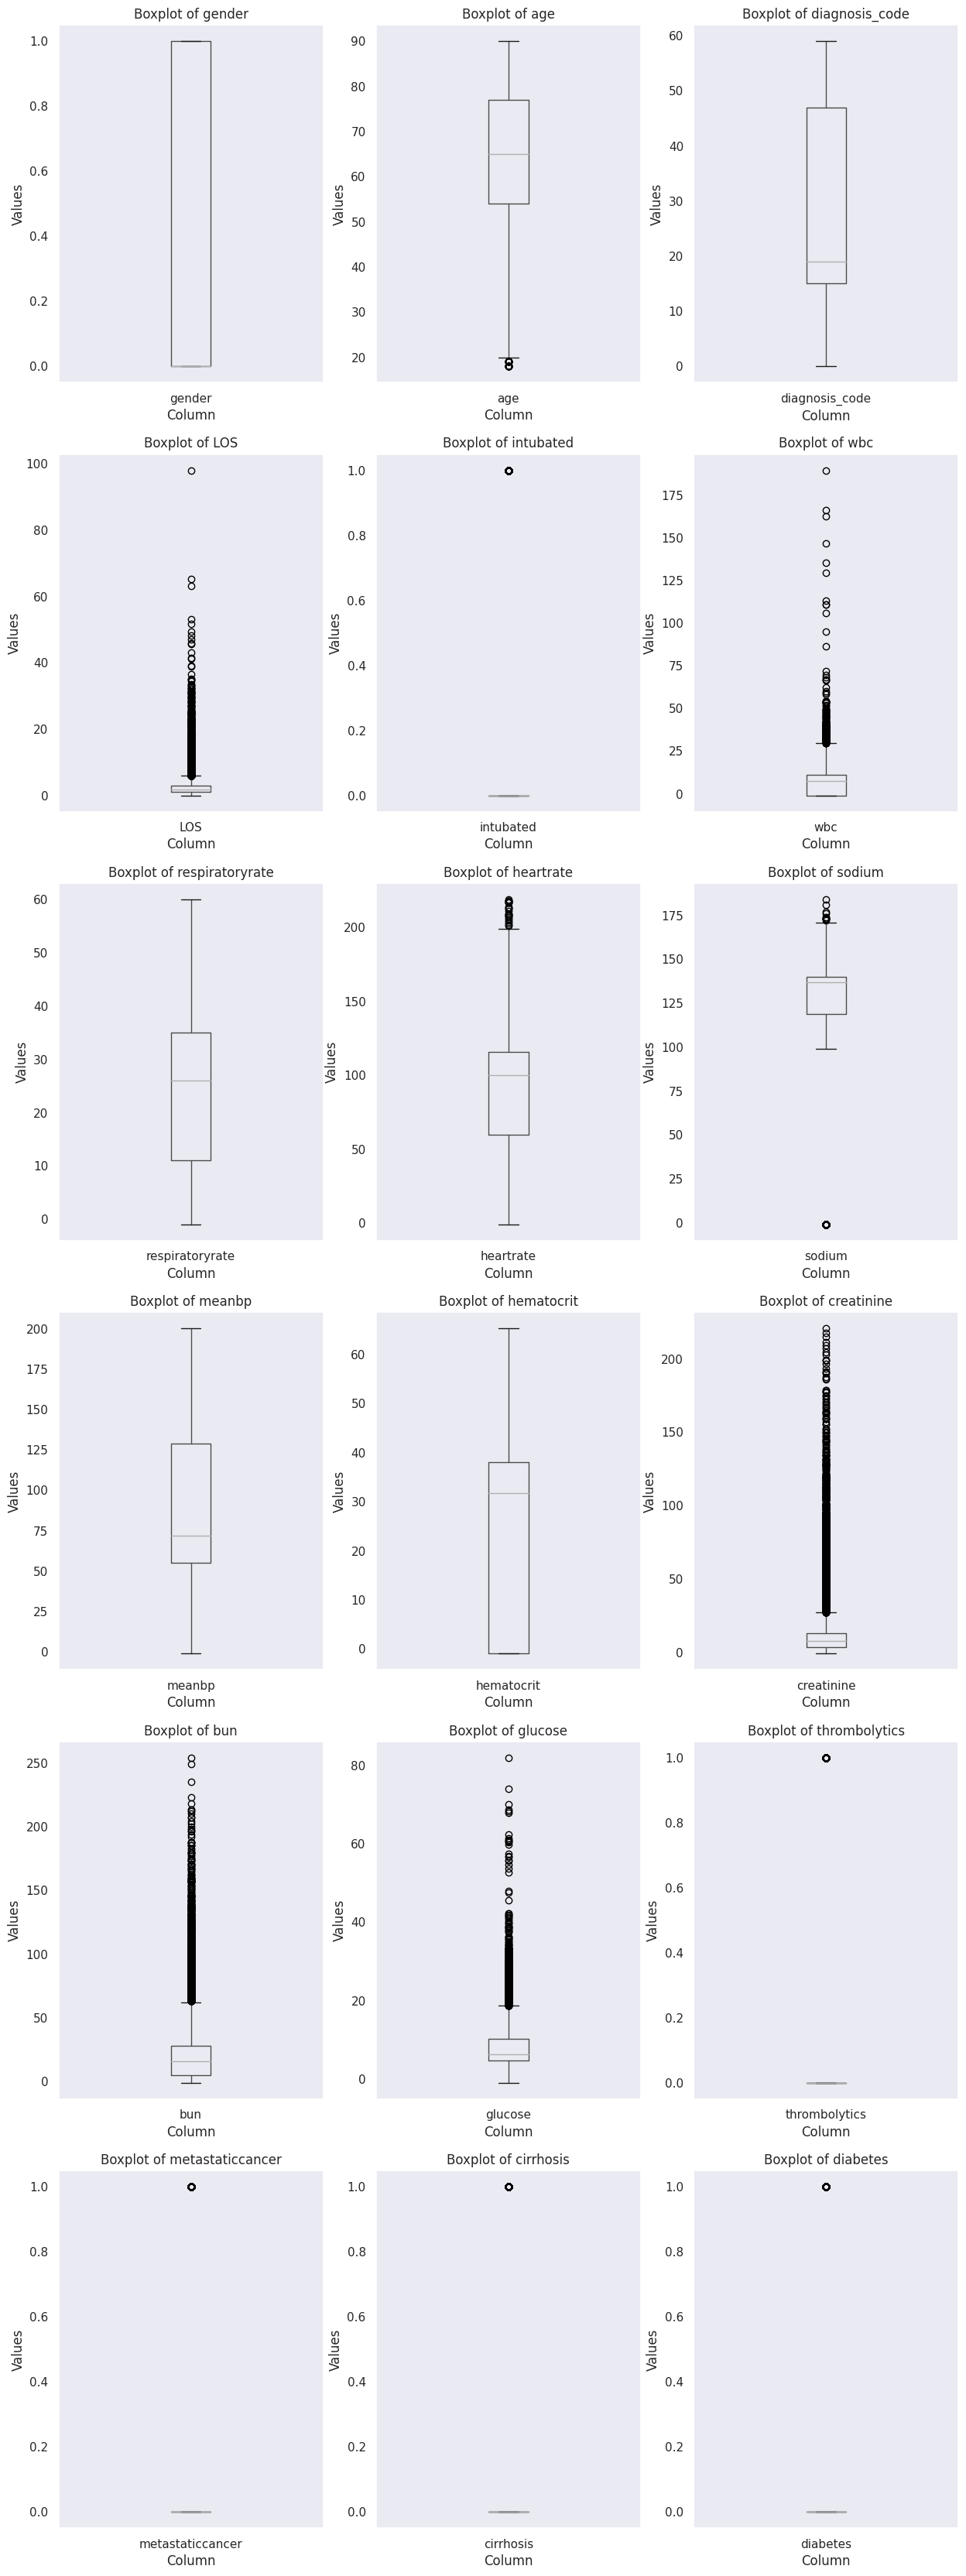

In [ ]:
# Select numeric columns only
numeric_columns = df_cardiac.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_cardiac.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

List of outliers identified by the stakeholders and supervisor :

- `wbc` - 4-11 is a normal value
- `heartrate` - remove any values that exceed 200
- `sodium` - remove the six dots that exceed 170

In [ ]:
# heartrate
df_cardiac = df_cardiac[df_cardiac['heartrate'] <= 200]

# sodium
df_cardiac = df_cardiac[df_cardiac['sodium'] <= 170]

#### Outliers less than 10 percentiles and `-1` values

In [ ]:
# column that consist of -1 values
negative_values = df_cardiac[(df_cardiac['wbc'] == -1) |
                           (df_cardiac['respiratoryrate'] == -1) | (df_cardiac['sodium'] == -1) |
                            (df_cardiac['heartrate'] == -1) | (df_cardiac['meanbp'] == -1) |
                             (df_cardiac['hematocrit'] == -1) | (df_cardiac['creatinine'] == -1) |
                              (df_cardiac['bun'] == -1) | (df_cardiac['glucose'] == -1) ]

len(negative_values)

6995

In [ ]:
len(df_cardiac)

20796

##### **Visualize the `-1` values**

The `-1` Values in several columns which denote for "**no data was entered**"



In [ ]:
# create a new df to understand the negative value problem
df_negative = df_cardiac.copy()

In [ ]:
df_negative.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000,20796.000000
mean,0.445663,64.539094,28.856319,2.669283,0.122668,7.507416,24.675111,93.986728,104.851707,92.207250,24.827234,12.387998,21.620018,7.514200,0.056068,0.011108,0.010964,0.233555
std,0.497051,15.960734,17.831417,3.489751,0.328063,8.092265,15.021044,32.976846,59.163246,42.660397,17.362097,19.424716,25.180747,6.198521,0.230059,0.104810,0.104134,0.423102
min,0.000000,18.000000,0.000000,-0.023611,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,0.979167,0.000000,-1.000000,11.000000,60.000000,119.000000,56.000000,-1.000000,3.712871,5.000000,4.700000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.676389,0.000000,7.500000,26.000000,99.000000,137.000000,72.000000,31.800000,7.779349,16.000000,6.200000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,2.960417,0.000000,11.300000,35.000000,116.000000,140.000000,129.000000,38.100000,13.083451,28.000000,10.300000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,98.013194,1.000000,189.700000,60.000000,199.000000,170.000000,200.000000,65.300000,220.562235,254.000000,82.000000,1.000000,1.000000,1.000000,1.000000


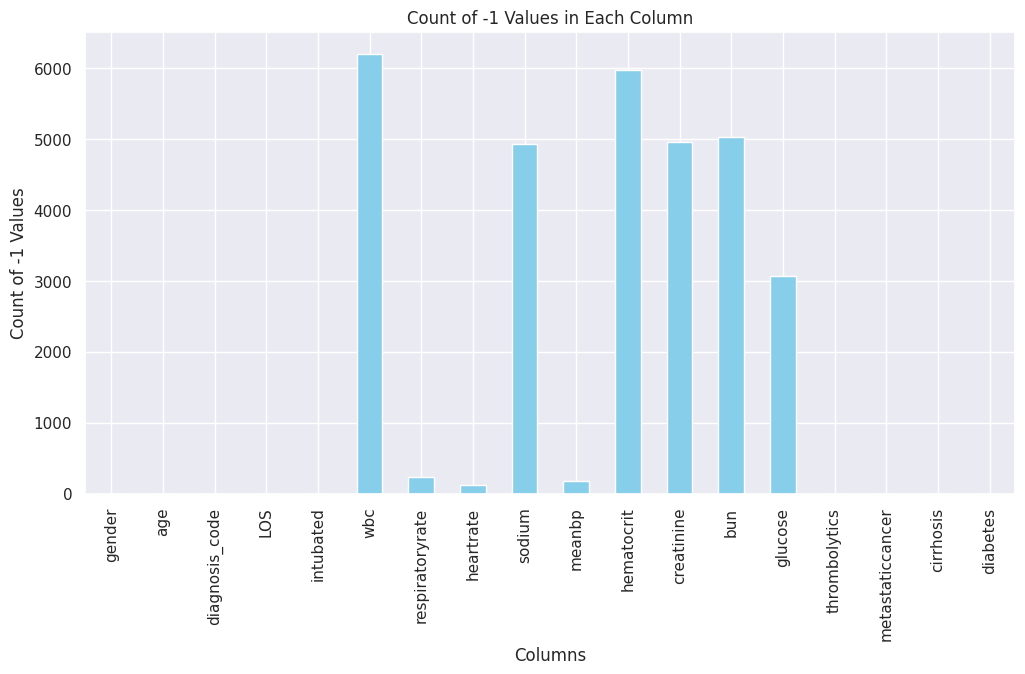

In [ ]:
# Replace -1 with NaN to prepare for visualization
df_negative.fillna(-1, inplace=True)

# Visualize the count of -1 values in each column
plt.figure(figsize=(12, 6))
missing_counts = df_negative.eq(-1).sum()
missing_counts.plot(kind='bar', color='skyblue')
plt.title('Count of -1 Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Count of -1 Values')
plt.xticks(rotation=90)
plt.show()

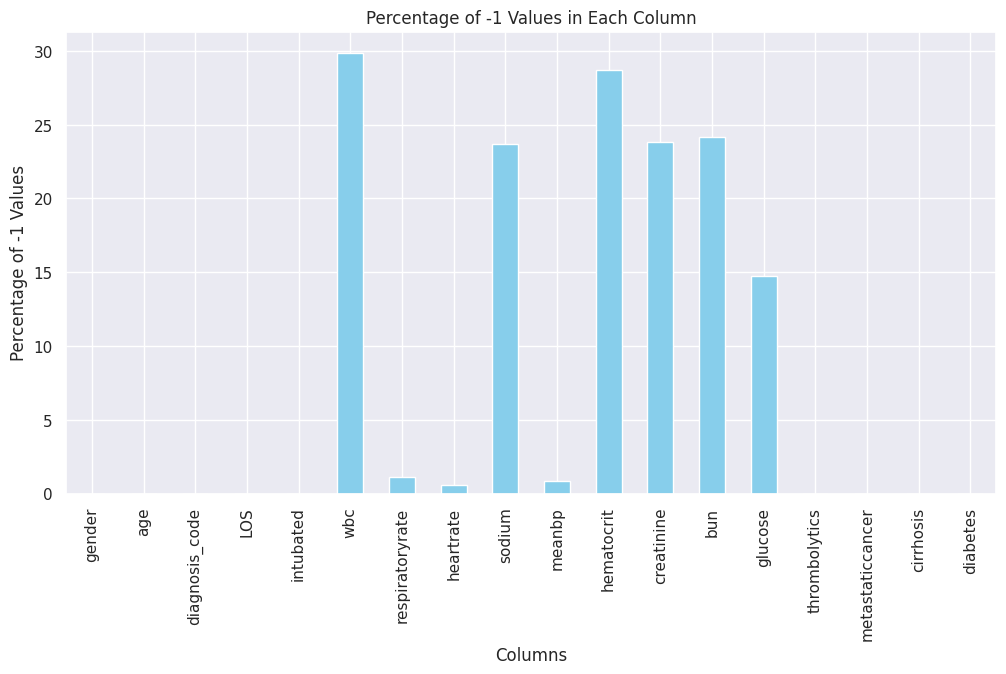

In [ ]:
# Calculate the percentage of -1 values in each column
percentage_missing = (df_negative.eq(-1).sum() / len(df_negative)) * 100

# Visualize the percentage of -1 values in each column
plt.figure(figsize=(12, 6))
percentage_missing.plot(kind='bar', color='skyblue')
plt.title('Percentage of -1 Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of -1 Values')
plt.xticks(rotation=90)
plt.show()

inference:

- It appears that the variables `wbc`, and `hematocrit` have nearly 30% of their values marked as "-1".
- `sodium`, `creatinine`, and `bun` come second with almost 25% data marked as "-1"

In [ ]:
df_negative.eq(-1).sum()

gender                 0
age                    0
diagnosis_code         0
LOS                    0
intubated              0
wbc                 6203
respiratoryrate      234
heartrate            115
sodium              4921
meanbp               174
hematocrit          5966
creatinine          4959
bun                 5026
glucose             3064
thrombolytics          0
metastaticcancer       0
cirrhosis              0
diabetes               0
dtype: int64

In [ ]:
# The -1 Values in several columns which denote for "no data was entered" were set to np.nan

# set the missing data to NaN
lst_clms = ['wbc', 'respiratoryrate', 'heartrate', 'sodium', 'meanbp',
            'hematocrit', 'creatinine', 'bun', 'glucose']
for clm in lst_clms:
    df_cardiac.loc[df_cardiac[clm] == -1, [clm]] = np.nan

In [ ]:
df_cardiac.isnull().sum()

gender                 0
age                    0
diagnosis_code         0
LOS                    0
intubated              0
wbc                 6203
respiratoryrate      234
heartrate            115
sodium              4921
meanbp               174
hematocrit          5966
creatinine          4959
bun                 5026
glucose             3064
thrombolytics          0
metastaticcancer       0
cirrhosis              0
diabetes               0
dtype: int64

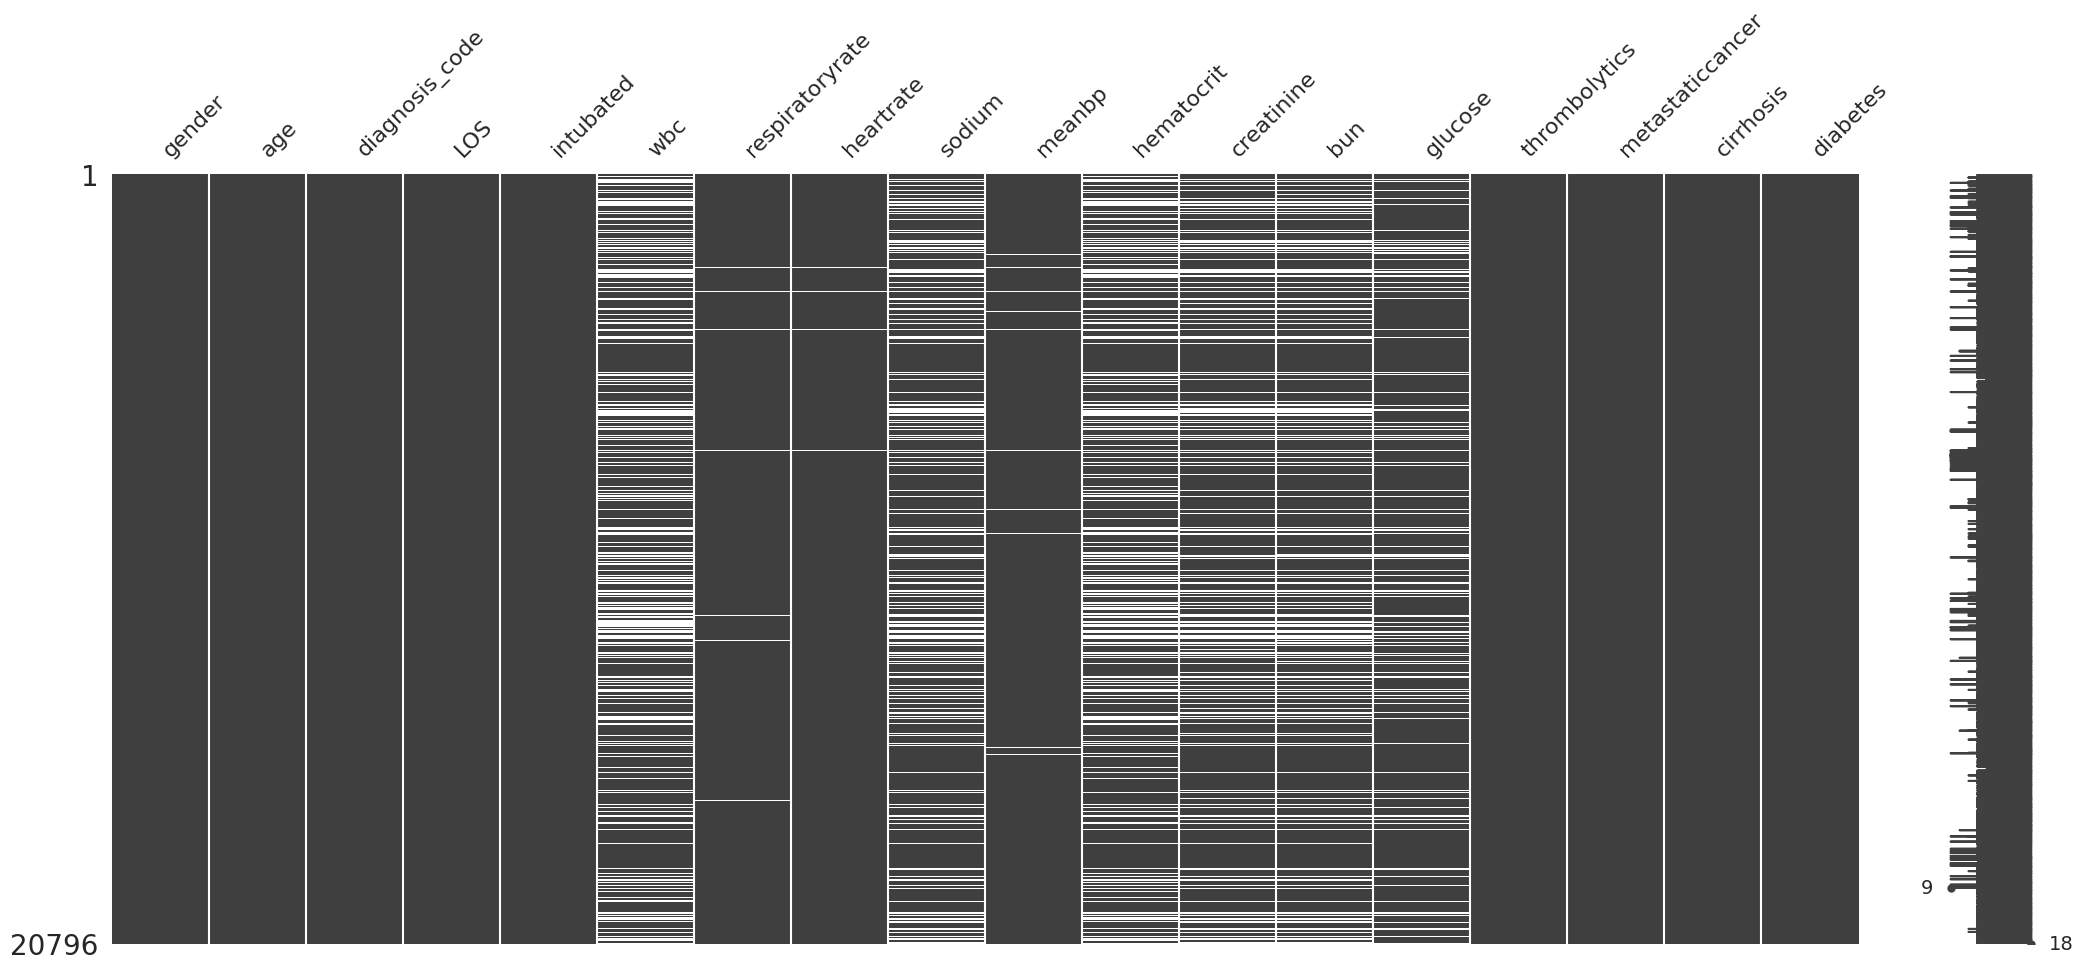

In [ ]:
msno.matrix(df_cardiac);

inference :

- As we can see, the NaN values between columns have some kind of relationship, especially on `wbc` and `hematocrit`

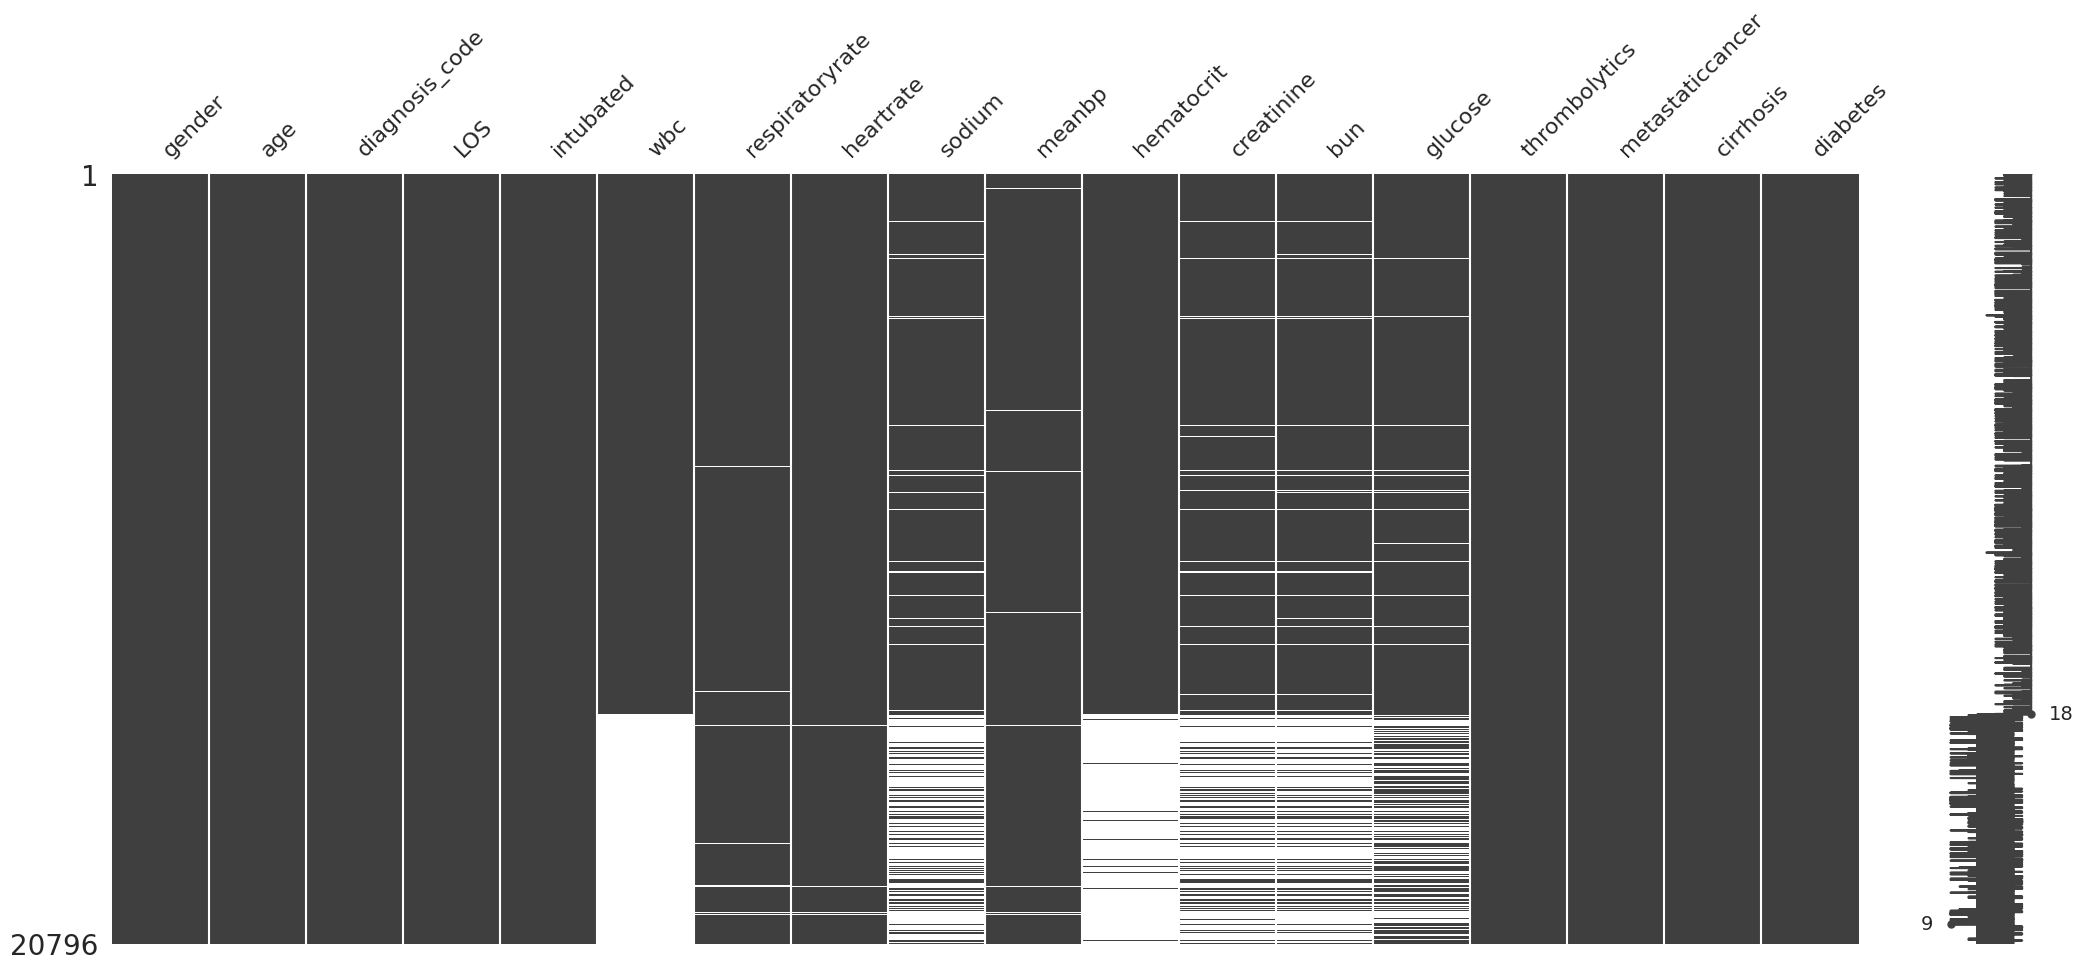

In [ ]:
msno.matrix(df_cardiac.sort_values("wbc"));

inference :

*   Our hypotheses is correct on the missing data relationship between `wbc` and `hematocrit`
*   let's see on `sodium` column



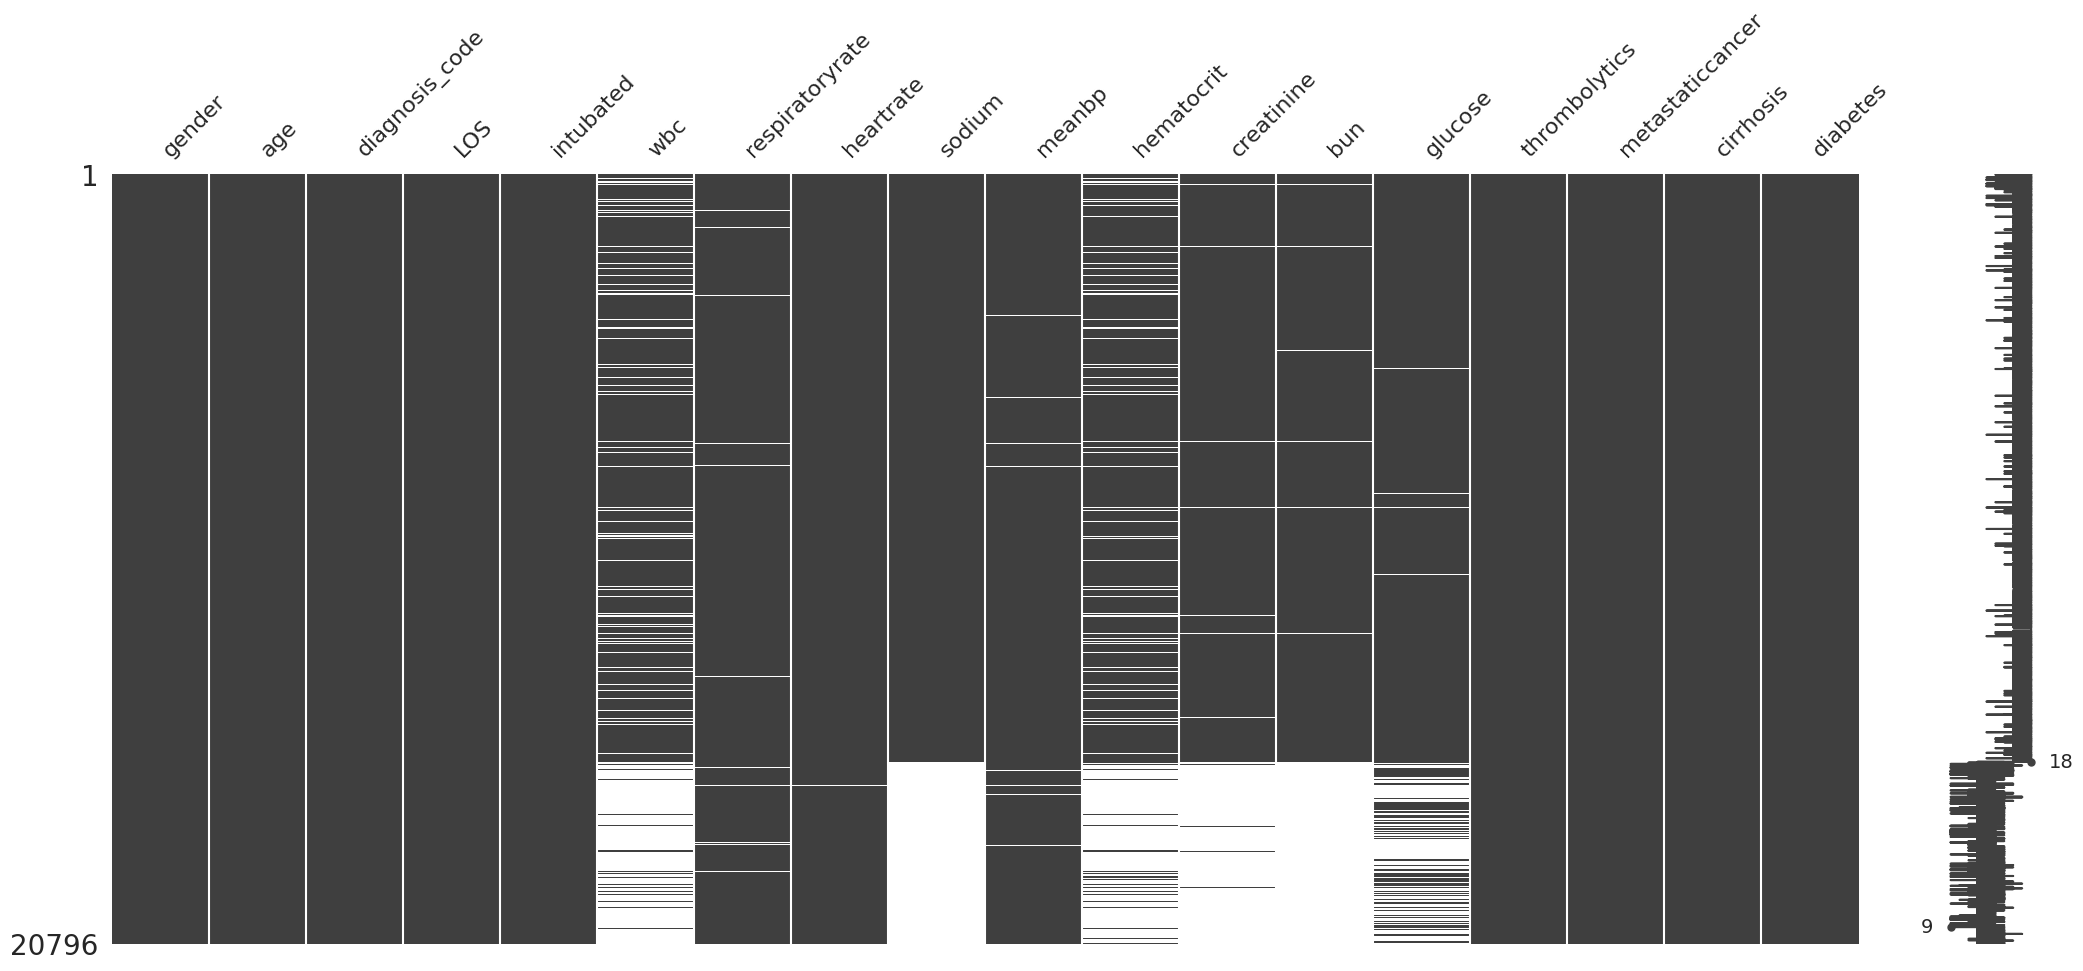

In [ ]:
msno.matrix(df_cardiac.sort_values("sodium"));

inference :

*   There're correlation between `sodium`, `creatinine`, and `bun`

In [ ]:
# Drop NaN values from columns contain null values
# columns_to_check = ['wbc', 'respiratoryrate', 'heartrate', 'sodium', 'meanbp']
# df_cardiac = df_cardiac.dropna(subset=columns_to_check)
df_cardiac = df_cardiac.dropna()

df_cardiac.isnull().sum()

gender              0
age                 0
diagnosis_code      0
LOS                 0
intubated           0
wbc                 0
respiratoryrate     0
heartrate           0
sodium              0
meanbp              0
hematocrit          0
creatinine          0
bun                 0
glucose             0
thrombolytics       0
metastaticcancer    0
cirrhosis           0
diabetes            0
dtype: int64

In [ ]:
# amount of data after we remove 282 rows
len(df_cardiac)

13801

##### **Check the new `min` values**

In [ ]:
len(df_cardiac)

13801

In [ ]:
# new data representation especially for min values
df_cardiac.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,0.438084,64.583364,29.021448,2.985273,0.155713,11.136074,25.049678,95.665459,137.739780,92.012269,35.181599,16.480731,28.696558,8.931063,0.057242,0.011159,0.012318,0.238678
std,0.496170,15.867244,17.787314,3.714468,0.362597,7.011856,14.869226,32.426198,5.761713,42.849547,6.795360,20.305575,24.622270,5.515682,0.232313,0.105047,0.110305,0.426291
min,0.000000,18.000000,0.000000,0.038194,0.000000,0.070000,4.000000,20.000000,99.000000,40.000000,7.700000,0.972419,2.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,1.087500,0.000000,7.180000,11.000000,61.000000,136.000000,55.000000,30.600000,6.983734,14.000000,5.300000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.850694,0.000000,9.500000,27.000000,101.000000,138.000000,70.000000,35.600000,9.724187,20.000000,6.900000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,3.260417,0.000000,13.340000,35.000000,118.000000,141.000000,129.000000,39.800000,16.089109,34.000000,11.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,98.013194,1.000000,189.700000,60.000000,199.000000,170.000000,200.000000,65.300000,220.562235,254.000000,82.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_cardiac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13801 entries, 3 to 21863
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            13801 non-null  int64  
 1   age               13801 non-null  float64
 2   diagnosis_code    13801 non-null  int64  
 3   LOS               13801 non-null  float64
 4   intubated         13801 non-null  float64
 5   wbc               13801 non-null  float64
 6   respiratoryrate   13801 non-null  float64
 7   heartrate         13801 non-null  float64
 8   sodium            13801 non-null  float64
 9   meanbp            13801 non-null  float64
 10  hematocrit        13801 non-null  float64
 11  creatinine        13801 non-null  float64
 12  bun               13801 non-null  float64
 13  glucose           13801 non-null  float64
 14  thrombolytics     13801 non-null  float64
 15  metastaticcancer  13801 non-null  float64
 16  cirrhosis         13801 non-null  float6

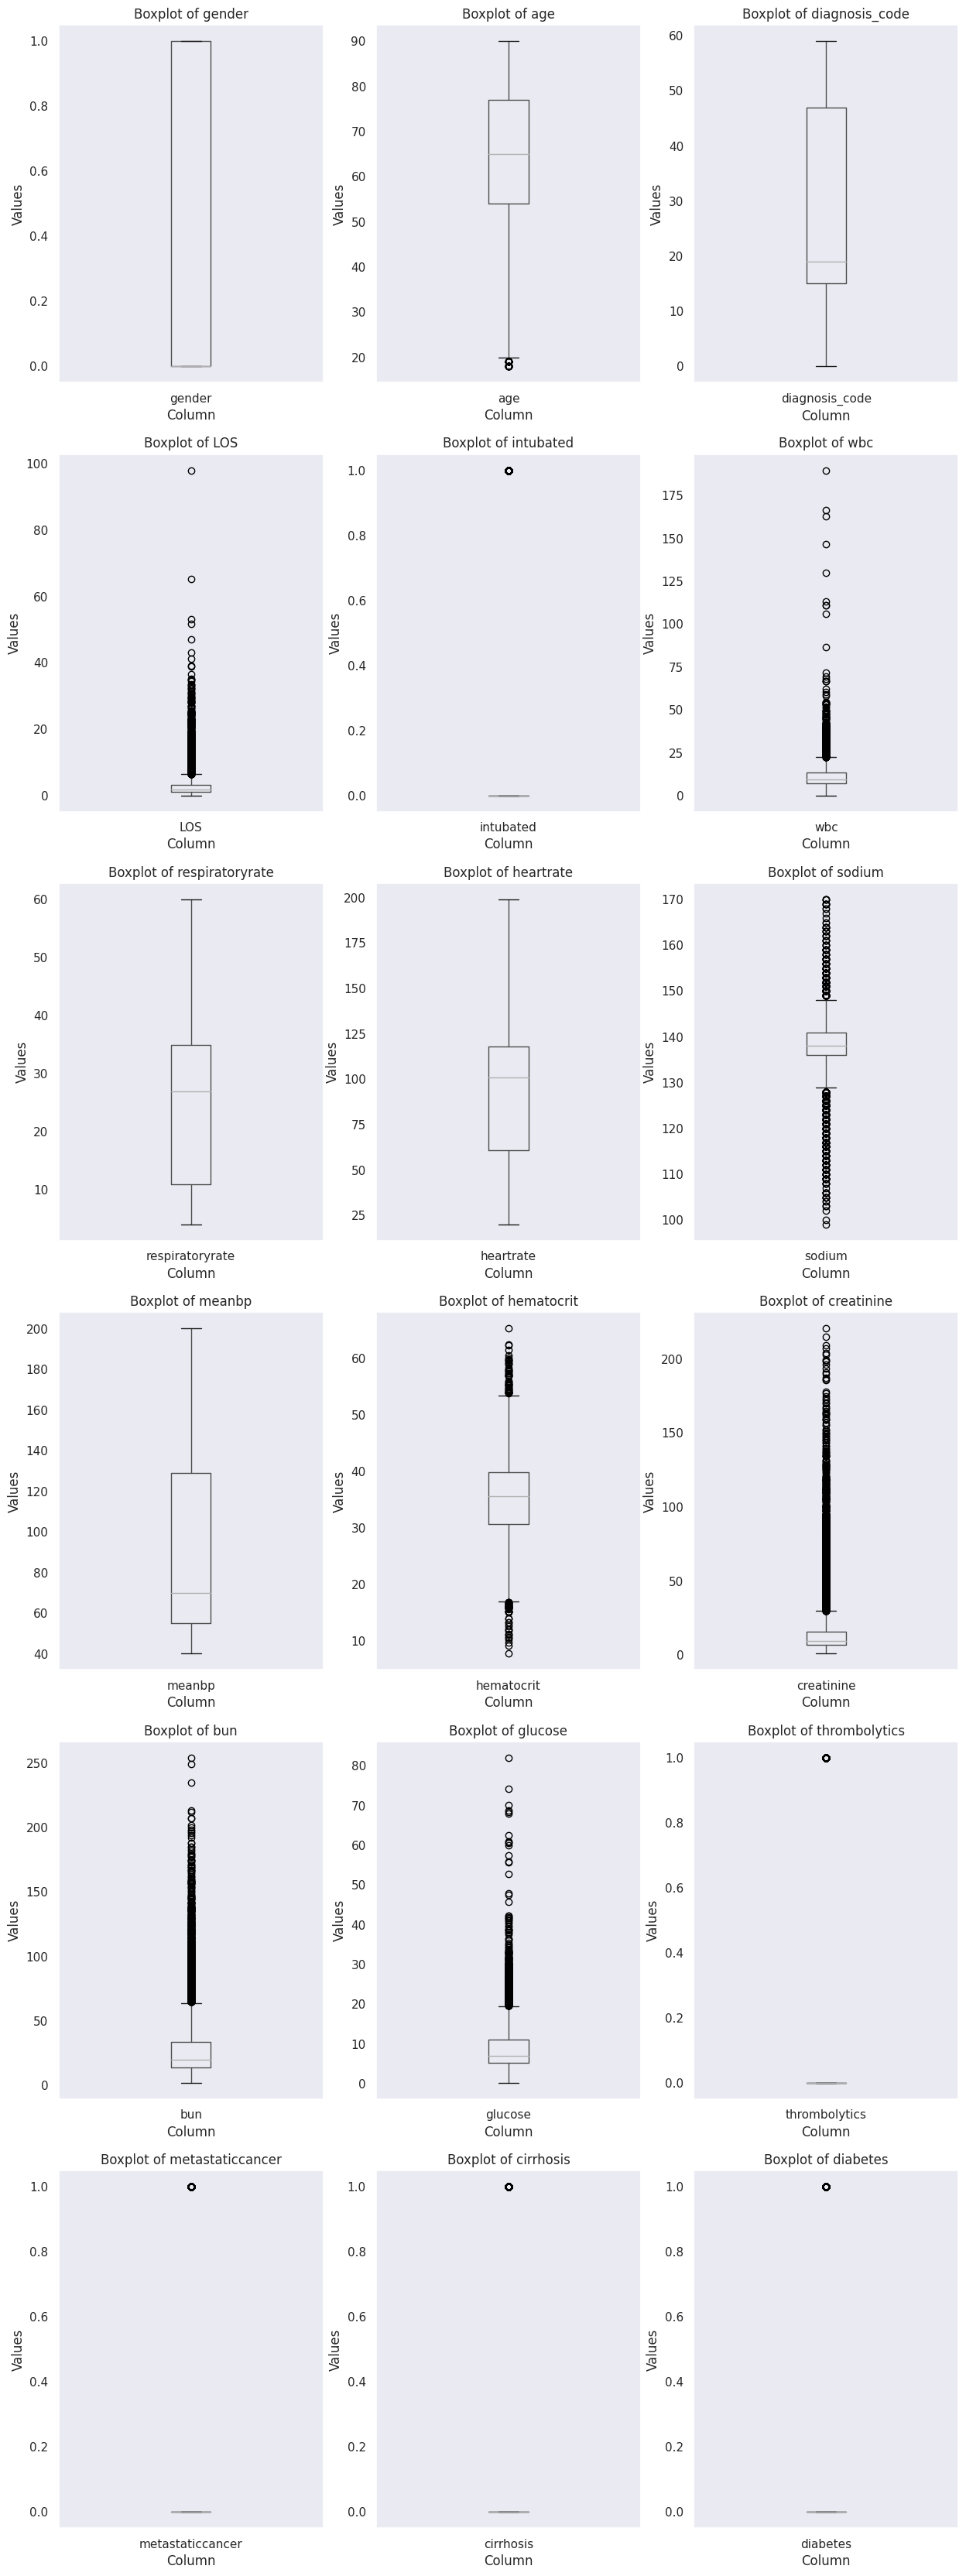

In [ ]:
# Select numeric columns only
numeric_columns = df_cardiac.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_cardiac.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

inference :
- There are no remaining outliers

In [ ]:
# Drop NaN values from all column
df_cardiac = df_cardiac.dropna()

df_cardiac.isnull().sum()

gender              0
age                 0
diagnosis_code      0
LOS                 0
intubated           0
wbc                 0
respiratoryrate     0
heartrate           0
sodium              0
meanbp              0
hematocrit          0
creatinine          0
bun                 0
glucose             0
thrombolytics       0
metastaticcancer    0
cirrhosis           0
diabetes            0
dtype: int64

In [ ]:
df_cardiac.shape

(13801, 18)

In [ ]:
df_cardiac.isnull().sum()

gender              0
age                 0
diagnosis_code      0
LOS                 0
intubated           0
wbc                 0
respiratoryrate     0
heartrate           0
sodium              0
meanbp              0
hematocrit          0
creatinine          0
bun                 0
glucose             0
thrombolytics       0
metastaticcancer    0
cirrhosis           0
diabetes            0
dtype: int64

In [ ]:
(df_cardiac == -1).sum()

gender              0
age                 0
diagnosis_code      0
LOS                 0
intubated           0
wbc                 0
respiratoryrate     0
heartrate           0
sodium              0
meanbp              0
hematocrit          0
creatinine          0
bun                 0
glucose             0
thrombolytics       0
metastaticcancer    0
cirrhosis           0
diabetes            0
dtype: int64

In [ ]:
df_cardiac.head(10)

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
3,0,46.0,6,1.504861,1.0,9.7,34.0,114.0,132.0,113.0,44.2,8.840170,15.0,7.9,0.0,0.0,0.0,0.0
6,1,53.0,46,1.292361,0.0,8.8,42.0,95.0,138.0,152.0,43.1,8.751768,22.0,5.5,0.0,0.0,0.0,0.0
8,1,71.0,46,0.660417,0.0,5.4,44.0,108.0,144.0,163.0,32.6,26.520509,27.0,8.7,0.0,0.0,0.0,0.0
9,1,58.0,47,2.274306,0.0,6.7,35.0,55.0,142.0,53.0,37.3,5.569307,13.0,4.9,0.0,0.0,0.0,0.0
10,1,88.0,16,1.995139,0.0,8.1,38.0,106.0,140.0,115.0,33.5,11.757426,22.0,14.3,0.0,0.0,0.0,0.0
11,0,59.0,17,2.720833,1.0,13.2,6.0,92.0,143.0,67.0,40.4,10.519802,22.0,4.7,0.0,0.0,0.0,0.0
12,0,48.0,54,0.690278,0.0,5.6,31.0,133.0,137.0,49.0,47.0,8.840170,8.0,5.3,0.0,0.0,0.0,0.0
13,1,77.0,15,0.764583,0.0,5.9,33.0,132.0,137.0,60.0,36.7,13.525460,17.0,14.8,0.0,0.0,0.0,1.0
14,1,90.0,47,2.493056,0.0,6.5,41.0,50.0,132.0,60.0,36.1,9.282178,17.0,6.0,0.0,0.0,0.0,0.0
15,0,67.0,52,5.839583,0.0,18.9,43.0,176.0,139.0,196.0,30.1,13.083451,21.0,22.1,0.0,0.0,0.0,1.0


## Converting this data to csv file

In [ ]:
df_cardiac.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,0.438084,64.583364,29.021448,2.985273,0.155713,11.136074,25.049678,95.665459,137.739780,92.012269,35.181599,16.480731,28.696558,8.931063,0.057242,0.011159,0.012318,0.238678
std,0.496170,15.867244,17.787314,3.714468,0.362597,7.011856,14.869226,32.426198,5.761713,42.849547,6.795360,20.305575,24.622270,5.515682,0.232313,0.105047,0.110305,0.426291
min,0.000000,18.000000,0.000000,0.038194,0.000000,0.070000,4.000000,20.000000,99.000000,40.000000,7.700000,0.972419,2.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,1.087500,0.000000,7.180000,11.000000,61.000000,136.000000,55.000000,30.600000,6.983734,14.000000,5.300000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.850694,0.000000,9.500000,27.000000,101.000000,138.000000,70.000000,35.600000,9.724187,20.000000,6.900000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,3.260417,0.000000,13.340000,35.000000,118.000000,141.000000,129.000000,39.800000,16.089109,34.000000,11.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,98.013194,1.000000,189.700000,60.000000,199.000000,170.000000,200.000000,65.300000,220.562235,254.000000,82.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_cardiac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13801 entries, 3 to 21863
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            13801 non-null  int64  
 1   age               13801 non-null  float64
 2   diagnosis_code    13801 non-null  int64  
 3   LOS               13801 non-null  float64
 4   intubated         13801 non-null  float64
 5   wbc               13801 non-null  float64
 6   respiratoryrate   13801 non-null  float64
 7   heartrate         13801 non-null  float64
 8   sodium            13801 non-null  float64
 9   meanbp            13801 non-null  float64
 10  hematocrit        13801 non-null  float64
 11  creatinine        13801 non-null  float64
 12  bun               13801 non-null  float64
 13  glucose           13801 non-null  float64
 14  thrombolytics     13801 non-null  float64
 15  metastaticcancer  13801 non-null  float64
 16  cirrhosis         13801 non-null  float6

In [ ]:
df_cardiac.isnull().sum()

gender              0
age                 0
diagnosis_code      0
LOS                 0
intubated           0
wbc                 0
respiratoryrate     0
heartrate           0
sodium              0
meanbp              0
hematocrit          0
creatinine          0
bun                 0
glucose             0
thrombolytics       0
metastaticcancer    0
cirrhosis           0
diabetes            0
dtype: int64

In [ ]:
(df_cardiac == -1).sum()

gender              0
age                 0
diagnosis_code      0
LOS                 0
intubated           0
wbc                 0
respiratoryrate     0
heartrate           0
sodium              0
meanbp              0
hematocrit          0
creatinine          0
bun                 0
glucose             0
thrombolytics       0
metastaticcancer    0
cirrhosis           0
diabetes            0
dtype: int64

In [ ]:
df_cardiac.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,0.438084,64.583364,29.021448,2.985273,0.155713,11.136074,25.049678,95.665459,137.739780,92.012269,35.181599,16.480731,28.696558,8.931063,0.057242,0.011159,0.012318,0.238678
std,0.496170,15.867244,17.787314,3.714468,0.362597,7.011856,14.869226,32.426198,5.761713,42.849547,6.795360,20.305575,24.622270,5.515682,0.232313,0.105047,0.110305,0.426291
min,0.000000,18.000000,0.000000,0.038194,0.000000,0.070000,4.000000,20.000000,99.000000,40.000000,7.700000,0.972419,2.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,1.087500,0.000000,7.180000,11.000000,61.000000,136.000000,55.000000,30.600000,6.983734,14.000000,5.300000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.850694,0.000000,9.500000,27.000000,101.000000,138.000000,70.000000,35.600000,9.724187,20.000000,6.900000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,3.260417,0.000000,13.340000,35.000000,118.000000,141.000000,129.000000,39.800000,16.089109,34.000000,11.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,98.013194,1.000000,189.700000,60.000000,199.000000,170.000000,200.000000,65.300000,220.562235,254.000000,82.000000,1.000000,1.000000,1.000000,1.000000


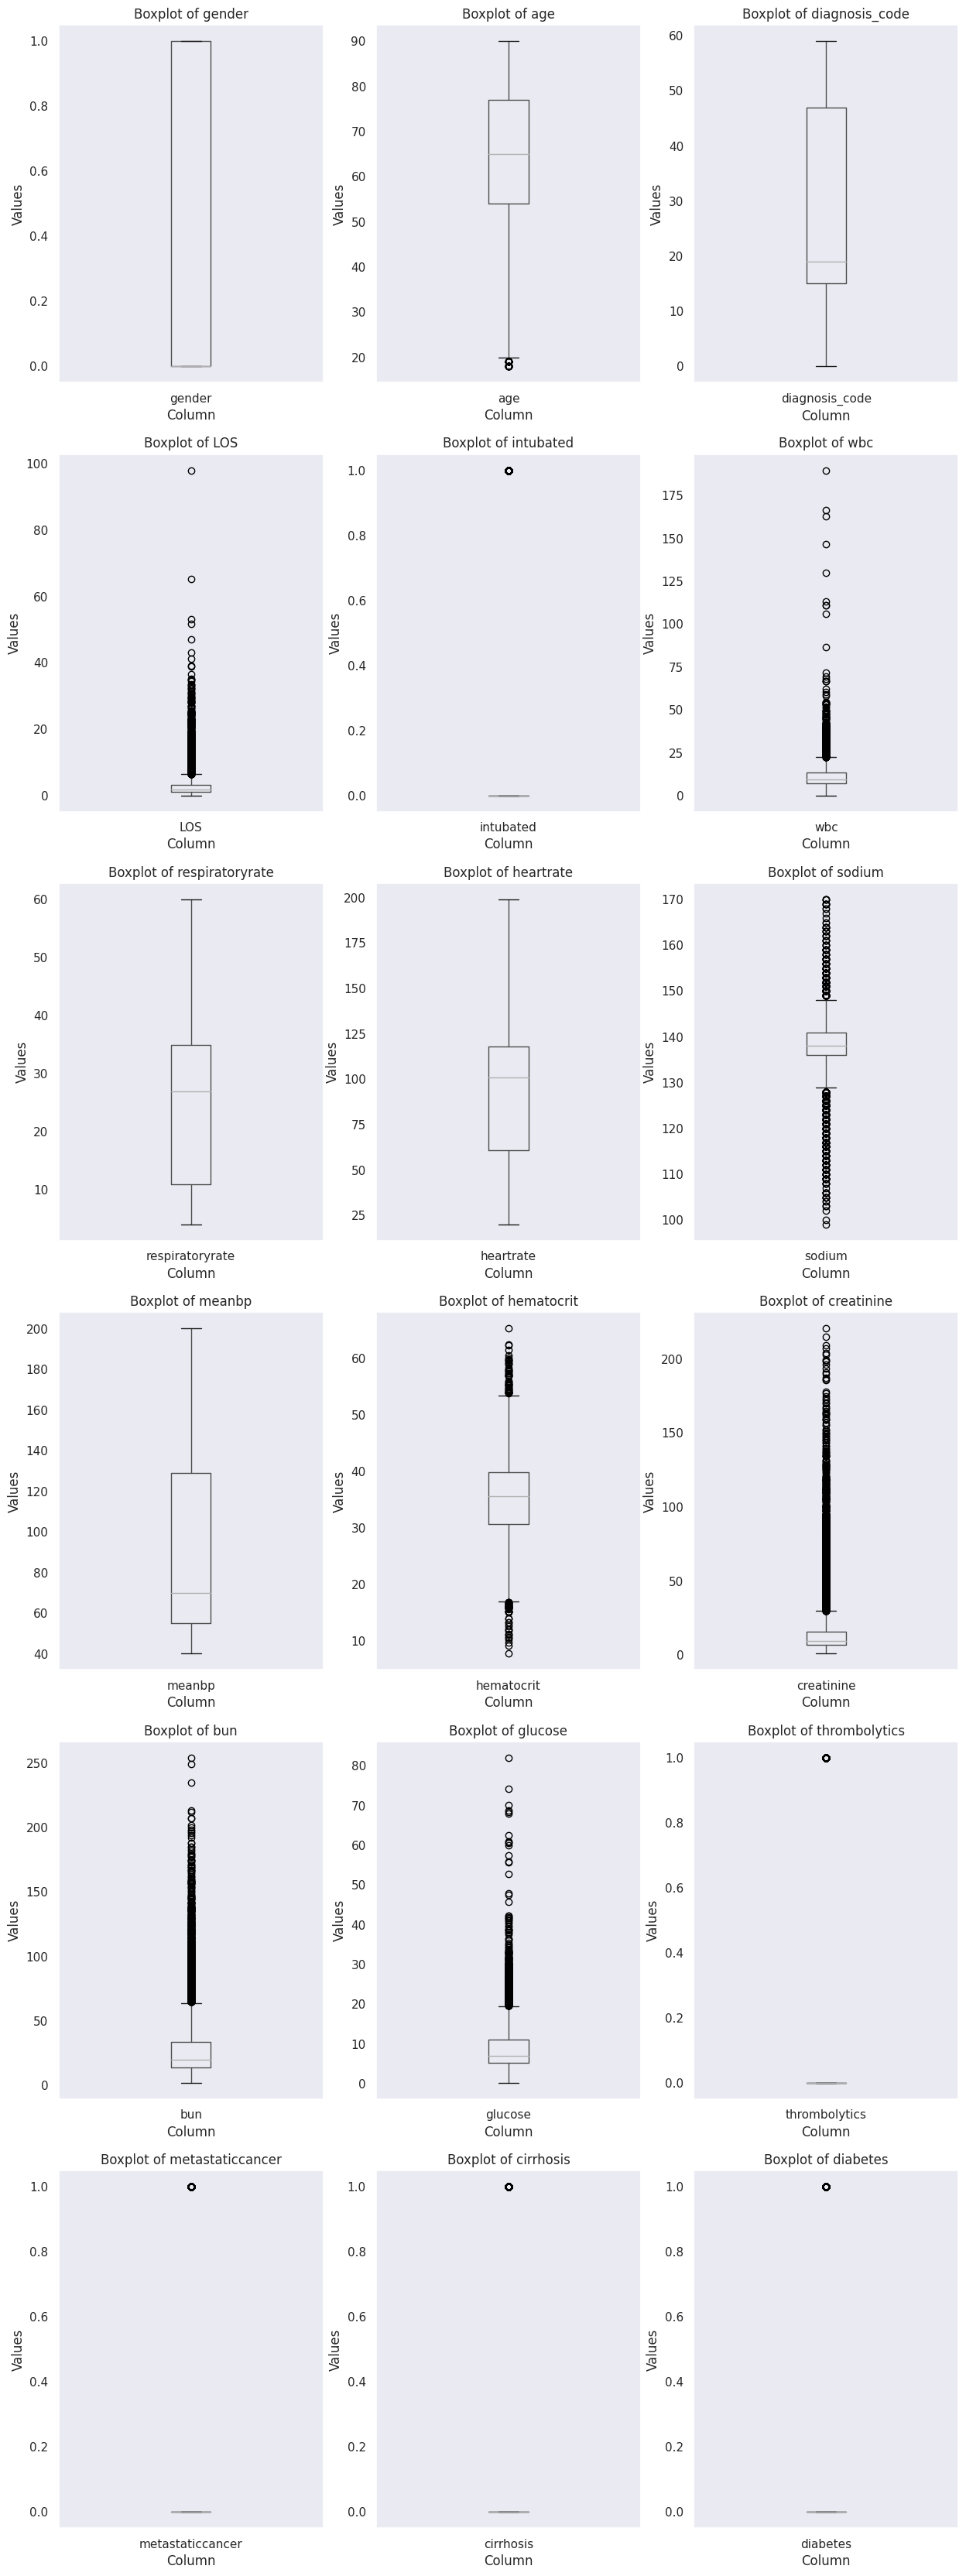

In [ ]:
# Select numeric columns only
numeric_columns = df_cardiac.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_cardiac.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

In [ ]:
# df_cardiac.to_csv('cardiac_ed.csv', index=False, header=True)

# from google.colab import files

# files.download('cardiac_ed.csv')

## Experiment

### Dataset with zero outliers

In [ ]:
df_no_outliers = df_cardiac.copy()

In [ ]:
df_no_outliers.describe(include="all")

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,0.438084,64.583364,29.021448,2.985273,0.155713,11.136074,25.049678,95.665459,137.739780,92.012269,35.181599,16.480731,28.696558,8.931063,0.057242,0.011159,0.012318,0.238678
std,0.496170,15.867244,17.787314,3.714468,0.362597,7.011856,14.869226,32.426198,5.761713,42.849547,6.795360,20.305575,24.622270,5.515682,0.232313,0.105047,0.110305,0.426291
min,0.000000,18.000000,0.000000,0.038194,0.000000,0.070000,4.000000,20.000000,99.000000,40.000000,7.700000,0.972419,2.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,1.087500,0.000000,7.180000,11.000000,61.000000,136.000000,55.000000,30.600000,6.983734,14.000000,5.300000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.850694,0.000000,9.500000,27.000000,101.000000,138.000000,70.000000,35.600000,9.724187,20.000000,6.900000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,3.260417,0.000000,13.340000,35.000000,118.000000,141.000000,129.000000,39.800000,16.089109,34.000000,11.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,98.013194,1.000000,189.700000,60.000000,199.000000,170.000000,200.000000,65.300000,220.562235,254.000000,82.000000,1.000000,1.000000,1.000000,1.000000


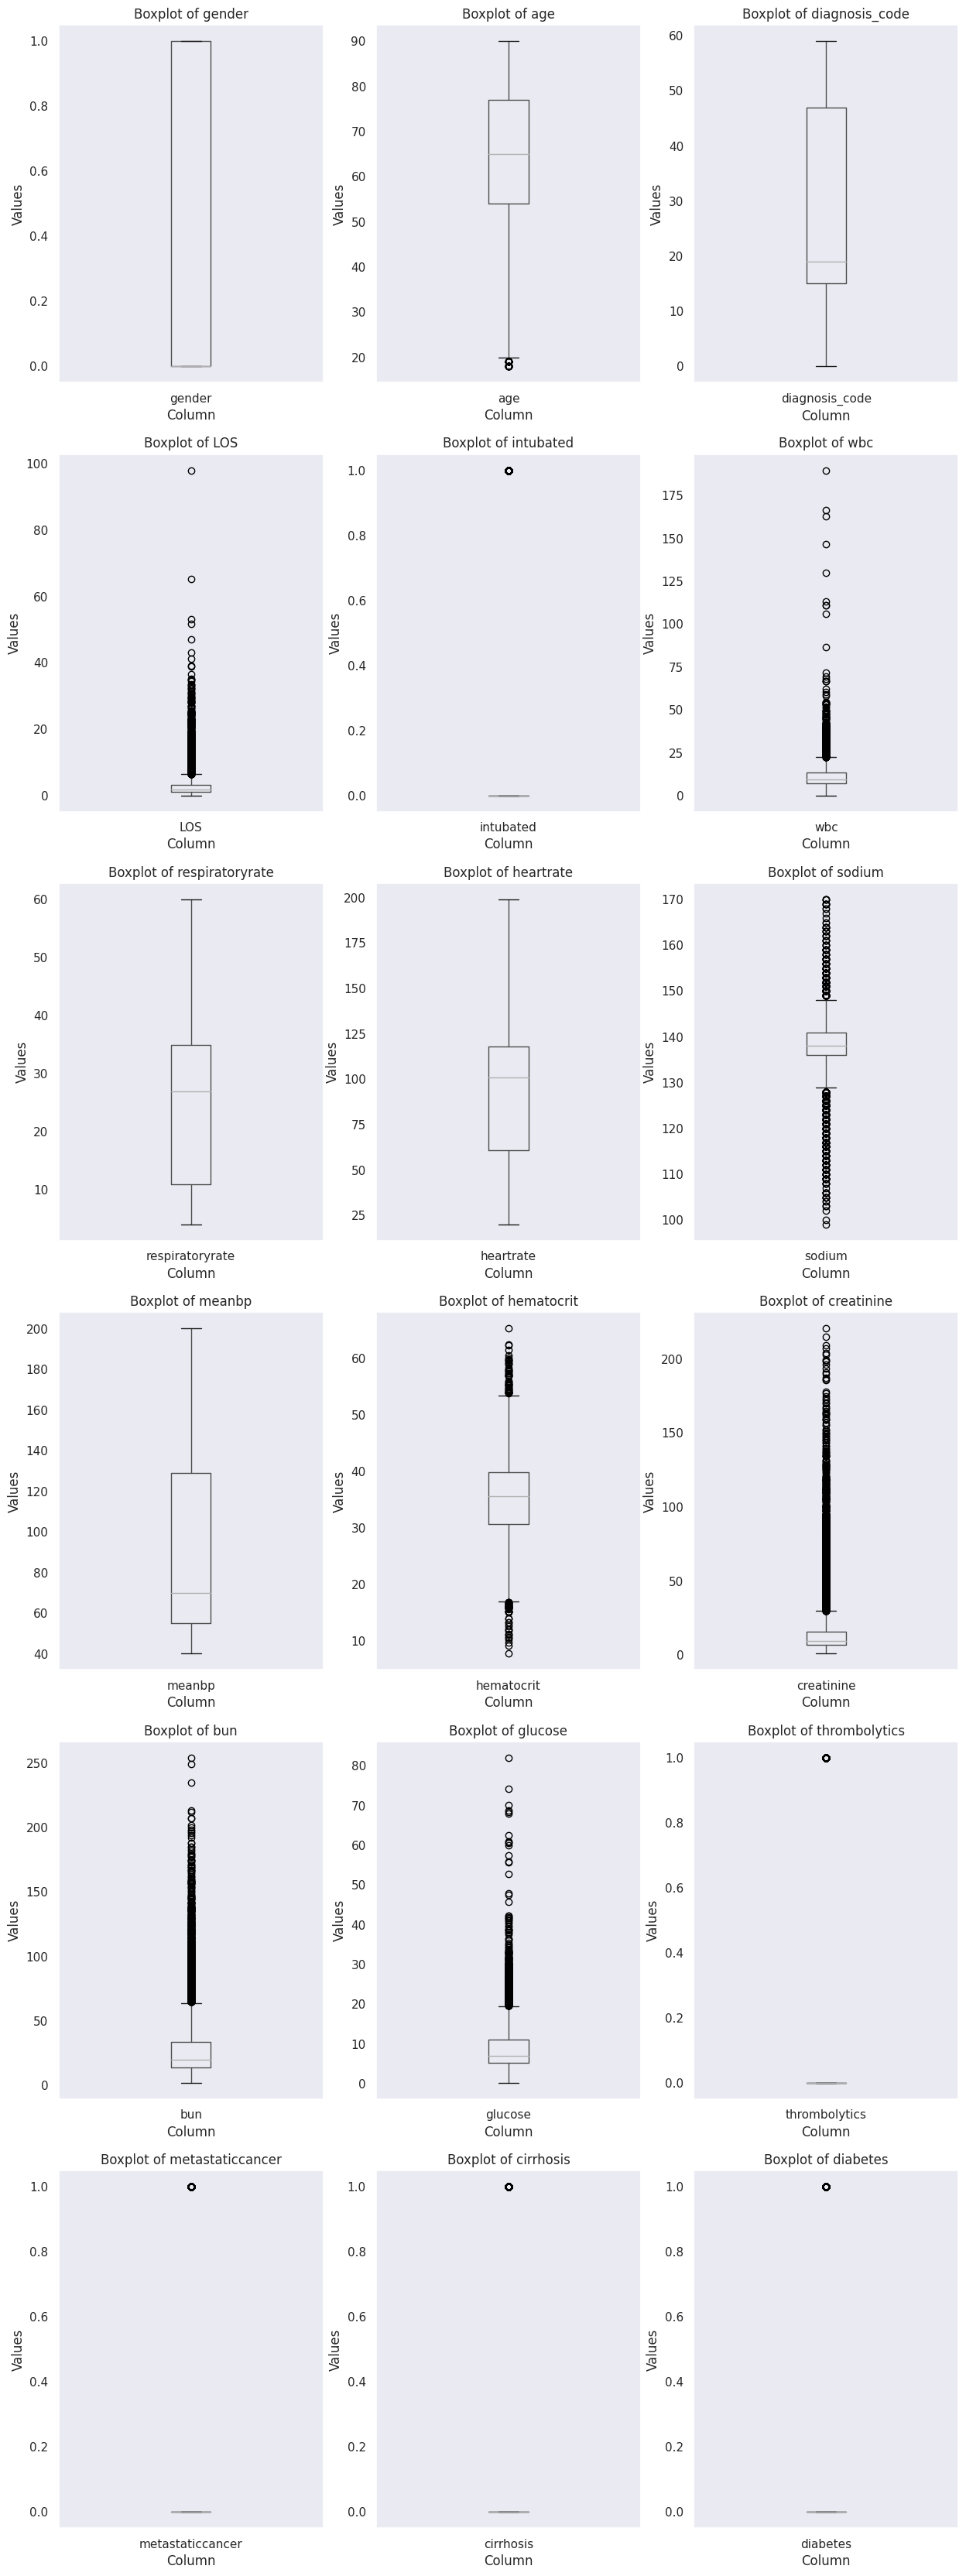

In [ ]:
# Select numeric columns only
numeric_columns = df_no_outliers.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_no_outliers.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

In [ ]:
df_no_outliers = df_no_outliers[df_no_outliers['age'] >= 20]

df_no_outliers = df_no_outliers[df_no_outliers['LOS'] <= 3.2]

df_no_outliers = df_no_outliers[(df_no_outliers['wbc'] >= 1) & (df_no_outliers['wbc'] <= 16)]

df_no_outliers = df_no_outliers[(df_no_outliers['sodium'] > 131) & (df_no_outliers['sodium'] <= 145.3)]

df_no_outliers = df_no_outliers[(df_no_outliers['hematocrit'] > 26) & (df_no_outliers['hematocrit'] <= 50)]

df_no_outliers = df_no_outliers[(df_no_outliers['creatinine'] > 2.3) & (df_no_outliers['creatinine'] < 12)]

df_no_outliers = df_no_outliers[df_no_outliers['bun'] <= 27]

df_no_outliers = df_no_outliers[(df_no_outliers['glucose'] > 3.5) & (df_no_outliers['glucose'] < 7.8)]

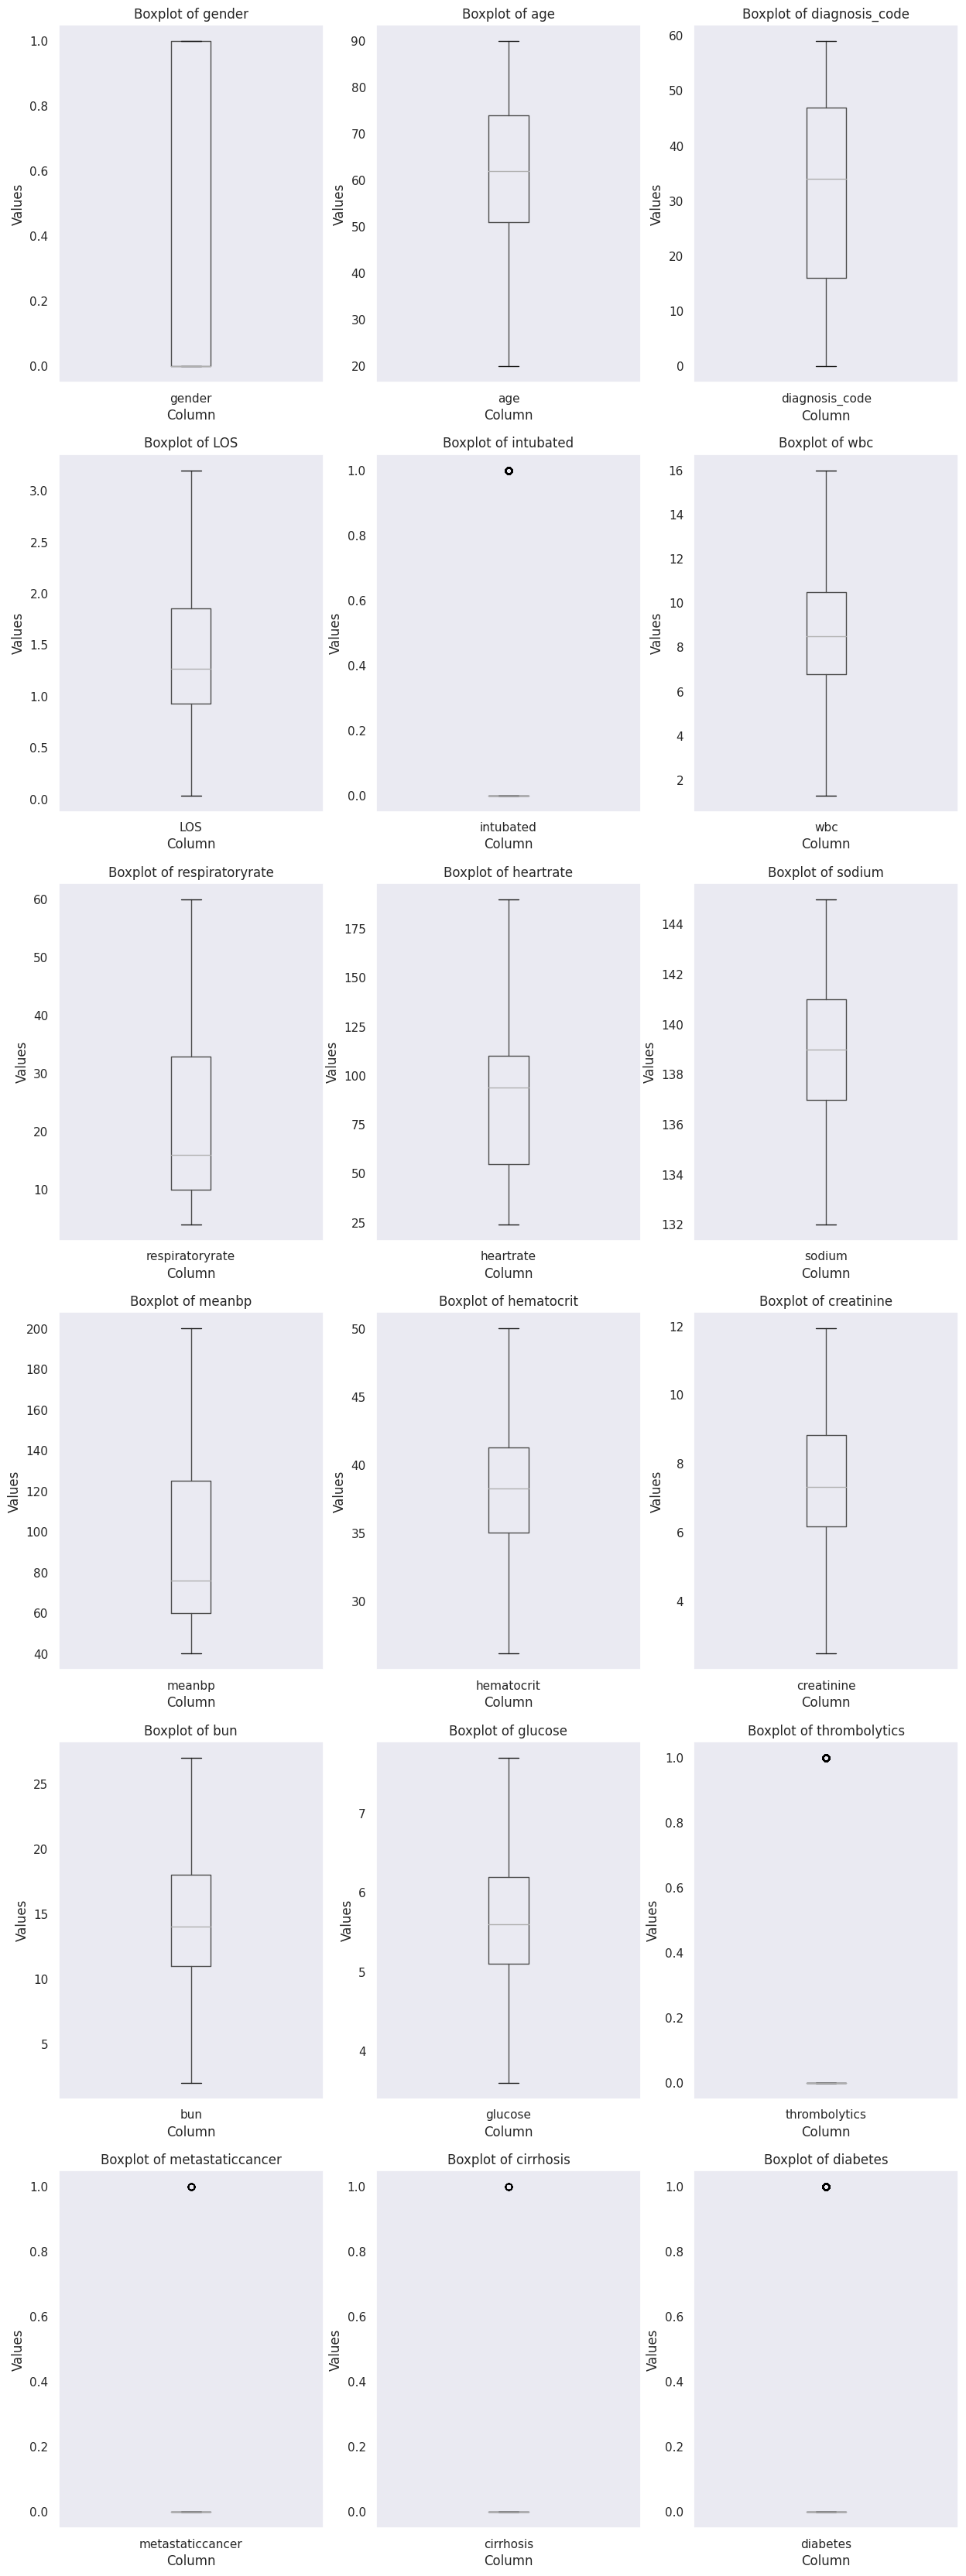

In [ ]:
# Select numeric columns only
numeric_columns = df_no_outliers.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_no_outliers.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

In [ ]:
df_no_outliers.shape

(3291, 18)

In [ ]:
df_no_outliers.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000
mean,0.431176,61.852628,31.577028,1.429641,0.039502,8.807770,22.726831,86.604983,138.985111,93.309328,38.085491,7.525128,14.392191,5.640626,0.085384,0.005469,0.004558,0.059860
std,0.495316,16.305793,17.102313,0.664417,0.194815,2.779006,14.708943,31.814998,2.762002,37.568398,4.645549,1.852614,4.887118,0.863001,0.279495,0.073764,0.067368,0.237264
min,0.000000,20.000000,0.000000,0.038194,0.000000,1.310000,4.000000,24.000000,132.000000,40.000000,26.200000,2.475248,2.000000,3.600000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,51.000000,16.000000,0.929861,0.000000,6.800000,10.000000,55.000000,137.000000,60.000000,35.050000,6.188119,11.000000,5.100000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,62.000000,34.000000,1.268750,0.000000,8.500000,16.000000,94.000000,139.000000,76.000000,38.300000,7.337341,14.000000,5.600000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,74.000000,47.000000,1.854861,0.000000,10.500000,33.000000,110.000000,141.000000,125.000000,41.300000,8.840170,18.000000,6.200000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,3.198611,1.000000,16.000000,60.000000,190.000000,145.000000,200.000000,50.000000,11.934229,27.000000,7.700000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# df_no_outliers.to_csv('cardiac_ed_no_outliers.csv', index=False, header=True)

# from google.colab import files

# files.download('cardiac_ed_no_outliers.csv')

### Dataset with Quantile based flooring and capping

In [ ]:
df_quantile = df_cardiac.copy()

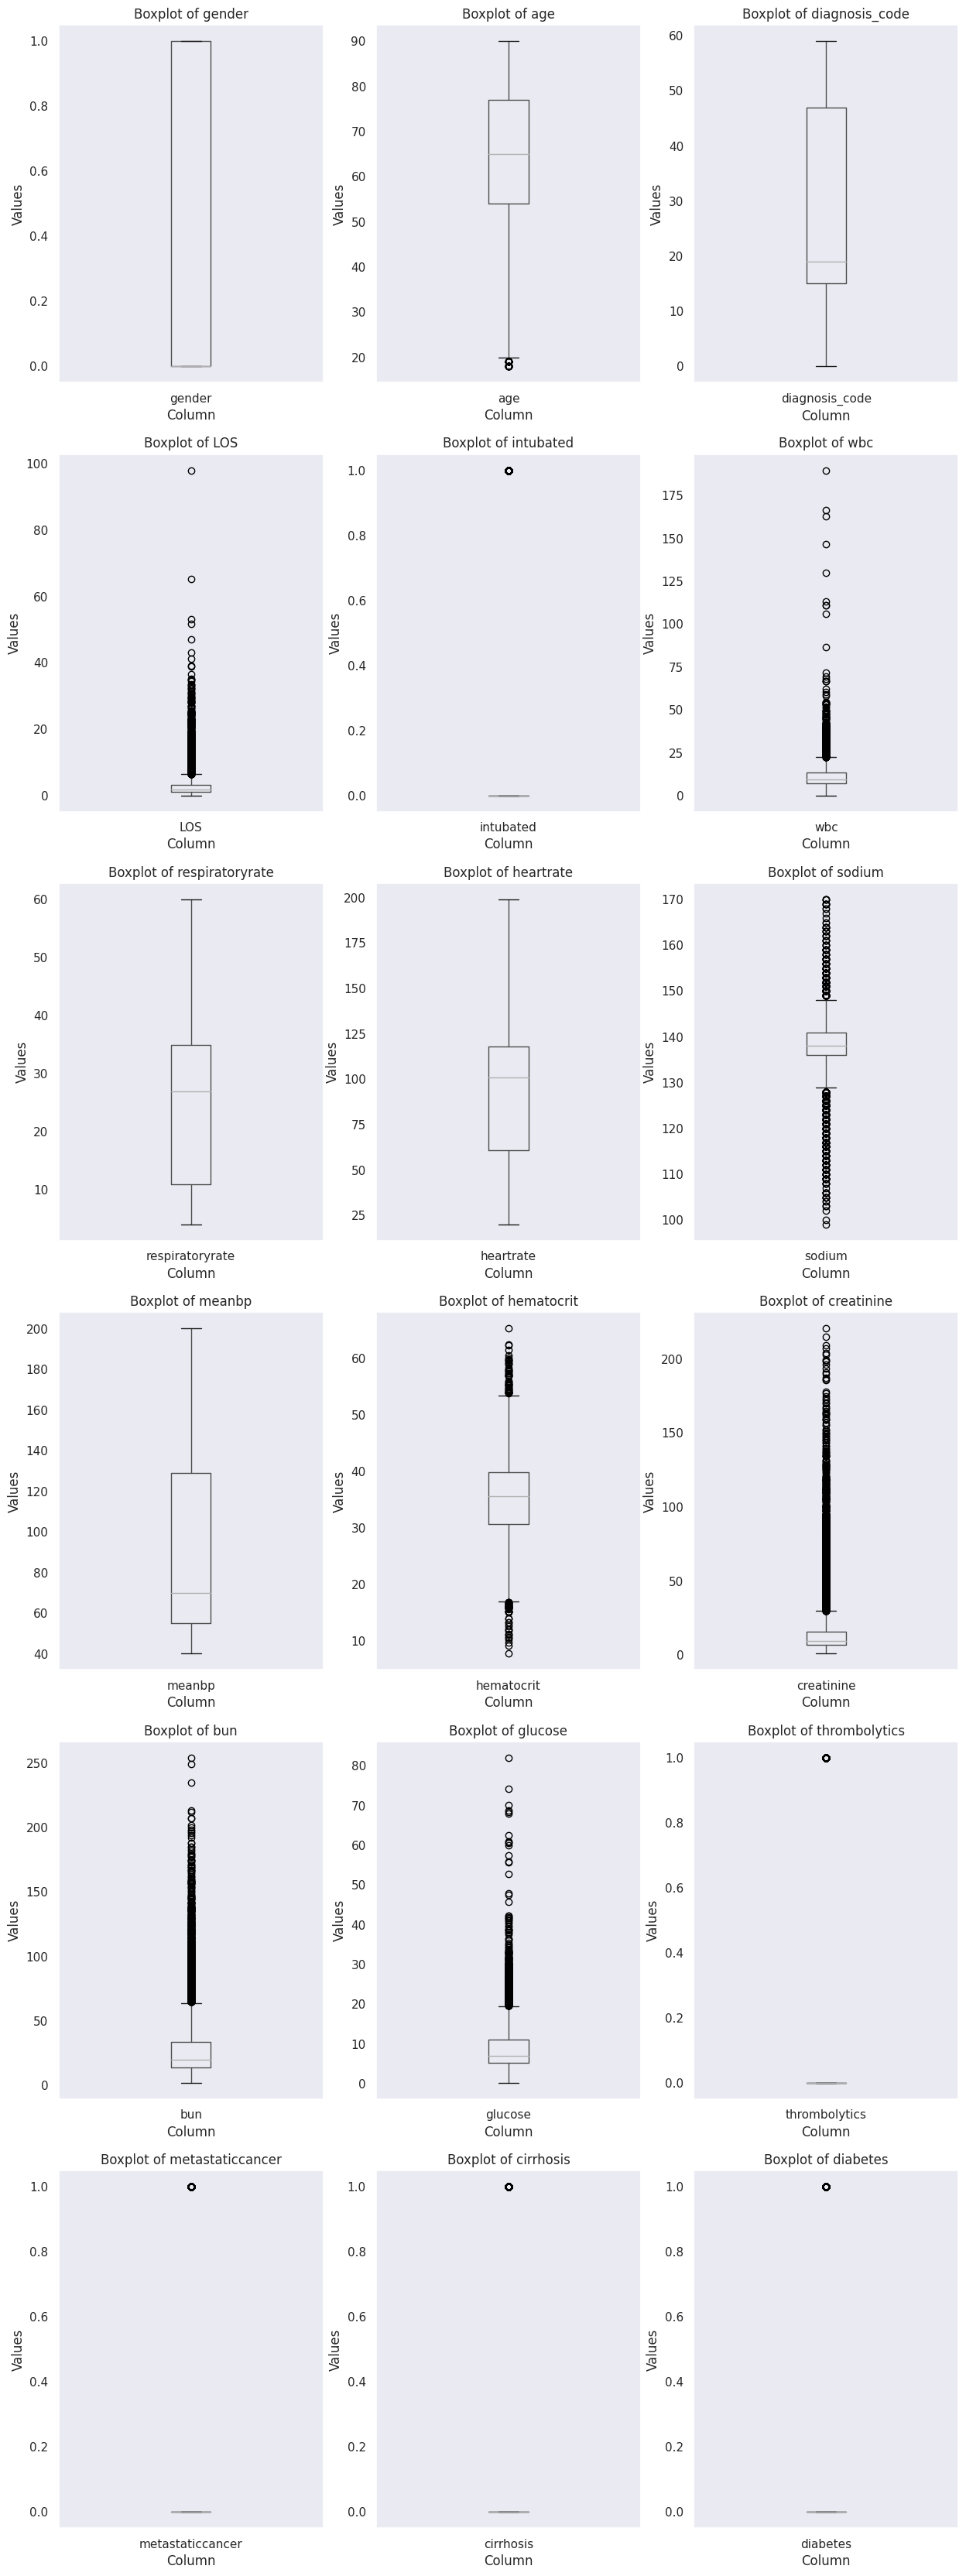

In [ ]:
# Select numeric columns only
numeric_columns = df_quantile.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_quantile.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

In [ ]:
# age
df_quantile['age'] = np.where(df_quantile['age'] < df_quantile['age'].quantile(0.10),
                                       df_quantile['age'].quantile(0.10),
                                       df_quantile['age'])

# LOS
df_quantile['LOS'] = np.where(df_quantile['LOS'] > df_quantile['LOS'].quantile(0.90),
                                       df_quantile['LOS'].quantile(0.90),
                                       df_quantile['LOS'])

# wbc
df_quantile['wbc'] = np.where(df_quantile['wbc'] > df_quantile['wbc'].quantile(0.90),
                                       df_quantile['wbc'].quantile(0.90),
                                       df_quantile['wbc'])

# sodium
df_quantile['sodium'] = np.where(df_quantile['sodium'] < df_quantile['sodium'].quantile(0.10),
                                       df_quantile['sodium'].quantile(0.10),
                                       df_quantile['sodium'])

df_quantile['sodium'] = np.where(df_quantile['sodium'] > df_quantile['sodium'].quantile(0.90),
                                       df_quantile['sodium'].quantile(0.90),
                                       df_quantile['sodium'])

# hematocrit
df_quantile['hematocrit'] = np.where(df_quantile['hematocrit'] < df_quantile['hematocrit'].quantile(0.10),
                                       df_quantile['hematocrit'].quantile(0.10),
                                       df_quantile['hematocrit'])

df_quantile['hematocrit'] = np.where(df_quantile['hematocrit'] > df_quantile['hematocrit'].quantile(0.90),
                                       df_quantile['hematocrit'].quantile(0.90),
                                       df_quantile['hematocrit'])

# creatinine
df_quantile['creatinine'] = np.where(df_quantile['creatinine'] > df_quantile['creatinine'].quantile(0.85),
                                       df_quantile['creatinine'].quantile(0.85),
                                       df_quantile['creatinine'])

# bun
df_quantile['bun'] = np.where(df_quantile['bun'] > df_quantile['bun'].quantile(0.90),
                                       df_quantile['bun'].quantile(0.90),
                                       df_quantile['bun'])

# glucose
df_quantile['glucose'] = np.where(df_quantile['glucose'] > df_quantile['glucose'].quantile(0.90),
                                       df_quantile['glucose'].quantile(0.90),
                                       df_quantile['glucose'])

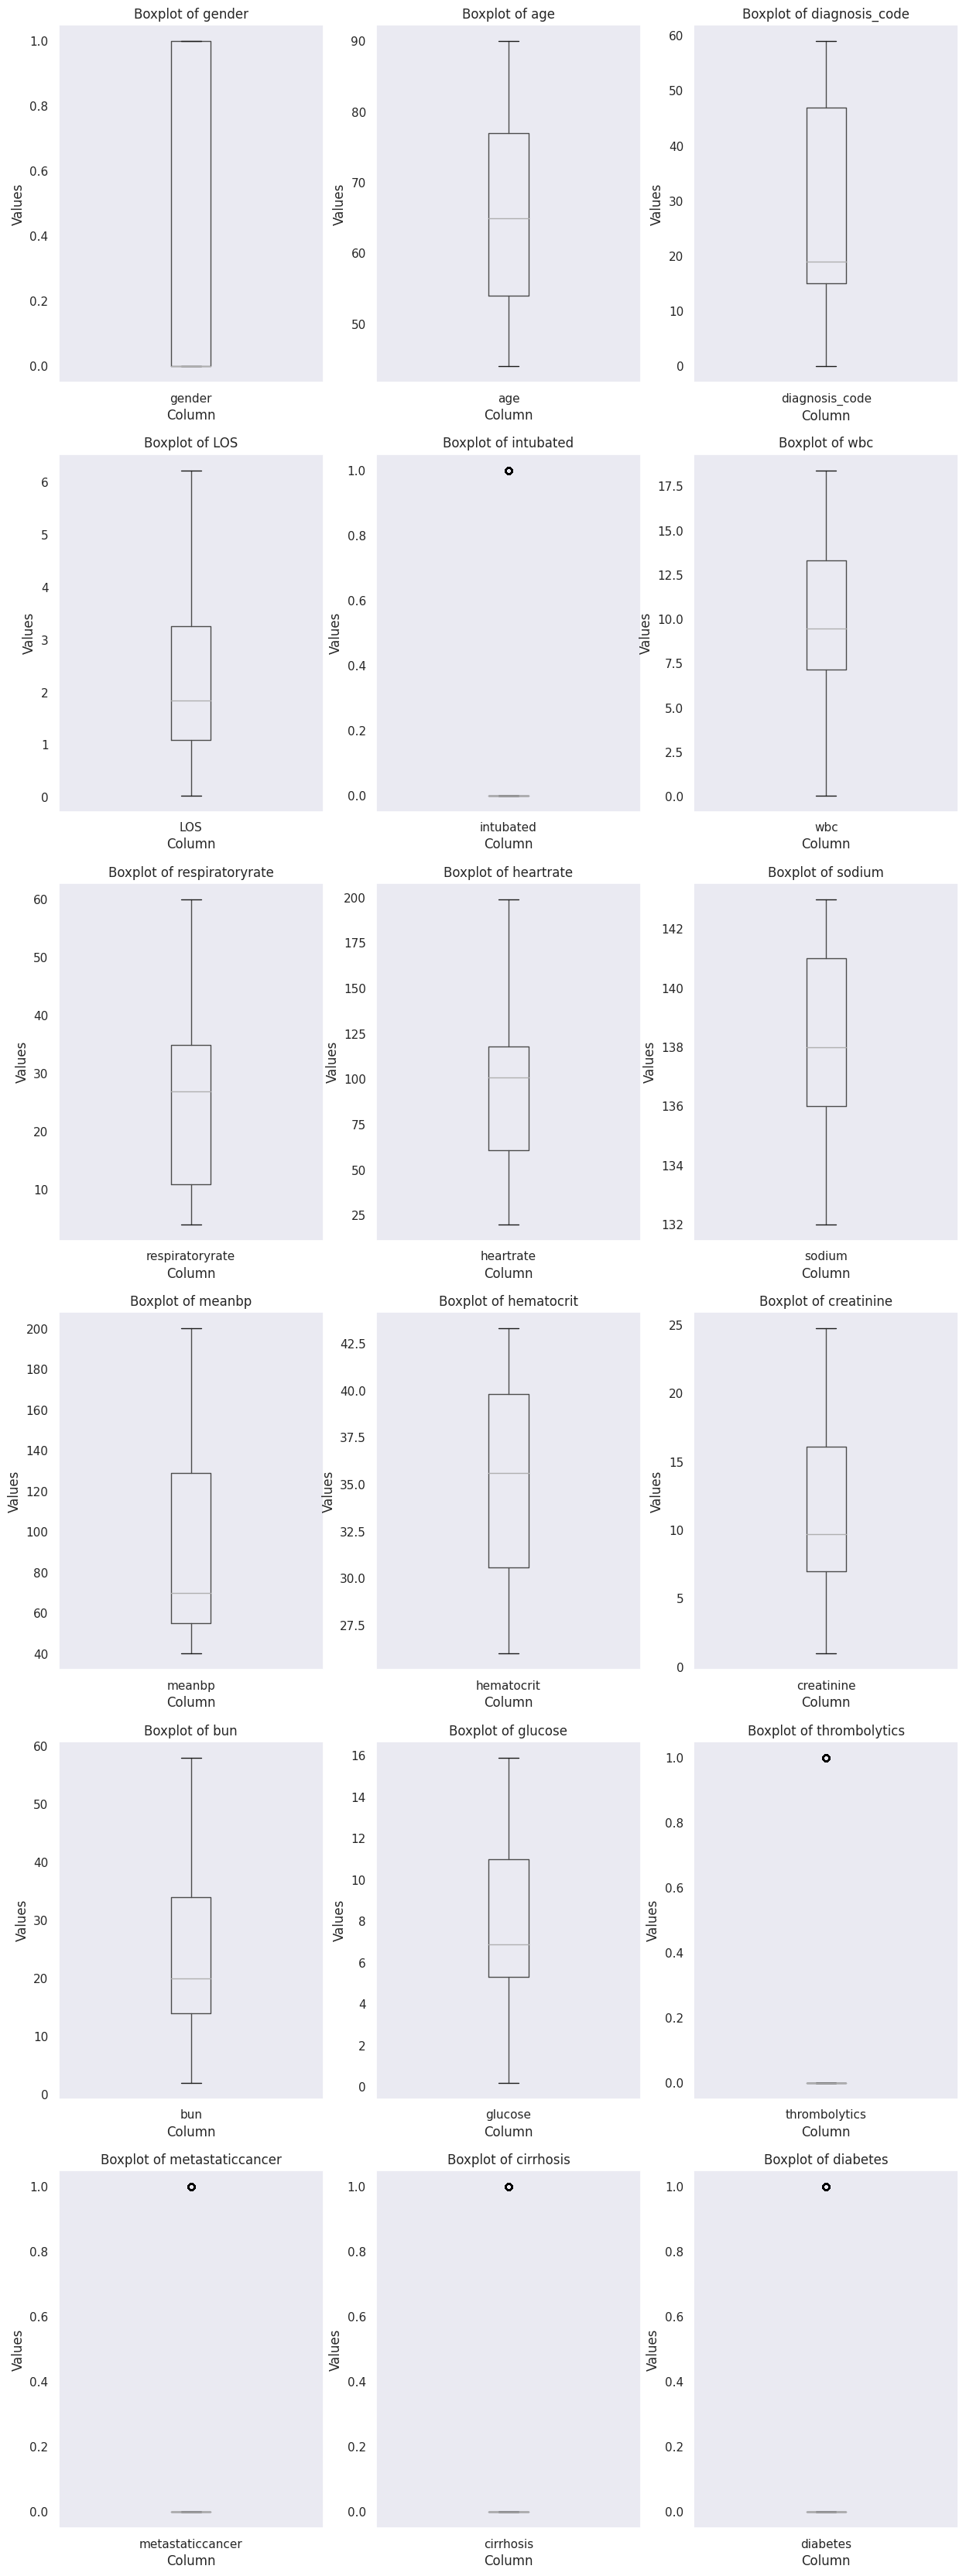

In [ ]:
# Select numeric columns only
numeric_columns = df_quantile.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_quantile.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

In [ ]:
df_quantile.shape

(13801, 18)

In [ ]:
df_cardiac.shape

(13801, 18)

In [ ]:
df_quantile.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,0.438084,65.577567,29.021448,2.458403,0.155713,10.407344,25.049678,95.665459,137.972574,92.012269,35.157449,12.129255,25.719738,8.385617,0.057242,0.011159,0.012318,0.238678
std,0.496170,13.960574,17.787314,1.766863,0.362597,4.313488,14.869226,32.426198,3.421915,42.849547,5.580079,6.806086,15.813584,3.909520,0.232313,0.105047,0.110305,0.426291
min,0.000000,44.000000,0.000000,0.038194,0.000000,0.070000,4.000000,20.000000,132.000000,40.000000,26.000000,0.972419,2.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,1.087500,0.000000,7.180000,11.000000,61.000000,136.000000,55.000000,30.600000,6.983734,14.000000,5.300000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.850694,0.000000,9.500000,27.000000,101.000000,138.000000,70.000000,35.600000,9.724187,20.000000,6.900000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,3.260417,0.000000,13.340000,35.000000,118.000000,141.000000,129.000000,39.800000,16.089109,34.000000,11.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,6.222917,1.000000,18.400000,60.000000,199.000000,143.000000,200.000000,43.300000,24.752475,58.000000,15.900000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# df_quantile.to_csv('cardiac_ed_quantile.csv', index=False, header=True)

# from google.colab import files

# files.download('cardiac_ed_quantile.csv')